In [3]:
#  Allows charts to appear in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Libraries for analysis
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from datetime import timedelta
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Libraries for visuals
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [4]:
df=pd.read_csv('df_without_index.csv')

In [5]:
df.columns

Index(['make', 'model', 'engine_type1', 'amateur_built', 'event_date',
       'location', 'country', 'injury_severity', 'purpose_of_flight',
       'weather_condition', 'broad_phase_of_flight', 'total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured',
       'people_on_board', 'phase_of_flight', 'latitude', 'longitude',
       'aircraft_damage', 'investigation_type', 'day_of_week', 'month',
       'no_of_engines1', 'pilot_type', 'fatalities'],
      dtype='object')

In [6]:
type(df)

pandas.core.frame.DataFrame

In [7]:
df.head()

,make,model,engine_type1,amateur_built,event_date,location,country,injury_severity,purpose_of_flight,weather_condition,broad_phase_of_flight,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,people_on_board,phase_of_flight,latitude,longitude,aircraft_damage,investigation_type,day_of_week,month,no_of_engines1,pilot_type,fatalities
0,hughes,369,turbine,no,2019-04-16,"Hauula, HI",United States,Non-Fatal,business,vmc,cruise,0.0,0.0,0.0,4.0,4.0,unknown,21.588333,-157.911944,substantial,accident,Tuesday,4,1,professional,non_fatal
1,robinson,r44,reciprocating,no,2019-04-04,"Tampa, FL",United States,Fatal(1),private,vmc,cruise,1.0,1.0,0.0,2.0,4.0,unknown,27.943333,-82.401944,substantial,accident,Thursday,4,1,private,fatal
2,robinson,r44,reciprocating,no,2019-04-02,"Taunton, MA",United States,Non-Fatal,instructional,vmc,maneuvering,0.0,0.0,0.0,2.0,2.0,unknown,41.874445,-71.016389,substantial,accident,Tuesday,4,1,instructional,non_fatal
3,bell,222,turbine,no,2019-03-30,"Montgomery, NY",United States,Non-Fatal,private,vmc,takeoff,0.0,0.0,1.0,5.0,5.0,unknown,41.539444,-74.306944,substantial,accident,Saturday,3,2,private,non_fatal
4,bell,206,turbine,no,2019-03-29,"Valley Center, CA",United States,Non-Fatal,survey,unknown,unknown,0.0,0.0,1.0,0.0,0.0,unknown,33.218370,-117.034197,substantial,accident,Friday,3,1,professional,non_fatal


##  

I've noticed that the people_on_board column that I made previously (with the assumption that headcount of fatal, serious, minor and uninjured people would give me the total number of people in the aircraft) did not include the minor injuries, so remaking the column correctly.

In [8]:

df['people_on_board']=df.total_fatal_injuries + df.total_serious_injuries + df.total_minor_injuries + df.total_uninjured
df.head()


,make,model,engine_type1,amateur_built,event_date,location,country,injury_severity,purpose_of_flight,weather_condition,broad_phase_of_flight,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,people_on_board,phase_of_flight,latitude,longitude,aircraft_damage,investigation_type,day_of_week,month,no_of_engines1,pilot_type,fatalities
0,hughes,369,turbine,no,2019-04-16,"Hauula, HI",United States,Non-Fatal,business,vmc,cruise,0.0,0.0,0.0,4.0,4.0,unknown,21.588333,-157.911944,substantial,accident,Tuesday,4,1,professional,non_fatal
1,robinson,r44,reciprocating,no,2019-04-04,"Tampa, FL",United States,Fatal(1),private,vmc,cruise,1.0,1.0,0.0,2.0,4.0,unknown,27.943333,-82.401944,substantial,accident,Thursday,4,1,private,fatal
2,robinson,r44,reciprocating,no,2019-04-02,"Taunton, MA",United States,Non-Fatal,instructional,vmc,maneuvering,0.0,0.0,0.0,2.0,2.0,unknown,41.874445,-71.016389,substantial,accident,Tuesday,4,1,instructional,non_fatal
3,bell,222,turbine,no,2019-03-30,"Montgomery, NY",United States,Non-Fatal,private,vmc,takeoff,0.0,0.0,1.0,5.0,6.0,unknown,41.539444,-74.306944,substantial,accident,Saturday,3,2,private,non_fatal
4,bell,206,turbine,no,2019-03-29,"Valley Center, CA",United States,Non-Fatal,survey,unknown,unknown,0.0,0.0,1.0,0.0,1.0,unknown,33.218370,-117.034197,substantial,accident,Friday,3,1,professional,non_fatal


In [9]:
df.tail()

,make,model,engine_type1,amateur_built,event_date,location,country,injury_severity,purpose_of_flight,weather_condition,broad_phase_of_flight,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,people_on_board,phase_of_flight,latitude,longitude,aircraft_damage,investigation_type,day_of_week,month,no_of_engines1,pilot_type,fatalities
2679,hughes,269,reciprocating,no,1982-01-15,"MALTA, ID",United States,Non-Fatal,unknown,vmc,maneuvering,0.0,0.0,0.0,1.0,1.0,unknown,42.971171,-73.792926,substantial,accident,Friday,1,1,unknown,non_fatal
2680,aerospatiale,as316,turbine,no,1982-01-06,"MAMMOTH LAKES, CA",United States,Non-Fatal,business,vmc,maneuvering,0.0,0.0,0.0,6.0,6.0,unknown,37.626801,-118.846750,substantial,accident,Wednesday,1,1,professional,non_fatal
2681,bell,47,reciprocating,no,1982-01-02,"MIAMI, FL",United States,Non-Fatal,private,vmc,cruise,0.0,0.0,0.0,2.0,2.0,unknown,25.774266,-80.193659,substantial,accident,Saturday,1,1,private,non_fatal
2682,enstrom,280,reciprocating,no,1982-01-02,"MIDWAY, UT",United States,Non-Fatal,private,imc,maneuvering,0.0,0.0,0.0,1.0,1.0,unknown,38.027639,-78.706408,destroyed,accident,Saturday,1,1,private,non_fatal
2683,bell,206,turbine,no,1982-01-02,"CHAMBLEE, GA",United States,Non-Fatal,unknown,vmc,approach,0.0,0.0,0.0,1.0,1.0,unknown,33.892176,-84.298830,substantial,accident,Saturday,1,1,unknown,non_fatal


In [10]:
df.dtypes

make                      object 
model                     object 
engine_type1              object 
amateur_built             object 
event_date                object 
location                  object 
country                   object 
injury_severity           object 
purpose_of_flight         object 
weather_condition         object 
broad_phase_of_flight     object 
total_fatal_injuries      float64
total_serious_injuries    float64
total_minor_injuries      float64
total_uninjured           float64
people_on_board           float64
phase_of_flight           object 
latitude                  float64
longitude                 float64
aircraft_damage           object 
investigation_type        object 
day_of_week               object 
month                     int64  
no_of_engines1            int64  
pilot_type                object 
fatalities                object 
dtype: object

In [11]:
df.describe()

,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,people_on_board,latitude,longitude,month,no_of_engines1
count,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000
mean,0.549553,0.247765,0.357303,1.087928,2.242548,34.090236,-79.063004,6.542474,1.074888
std,1.361087,0.663245,0.895665,1.448745,1.729693,16.614081,61.557776,3.098949,0.263260
min,0.000000,0.000000,0.000000,0.000000,0.000000,-46.141439,-170.478889,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,30.520834,-112.199653,4.000000,1.000000
50%,0.000000,0.000000,0.000000,1.000000,2.000000,36.425278,-93.101503,7.000000,1.000000
75%,0.000000,0.000000,0.000000,2.000000,3.000000,42.125980,-78.979167,9.000000,1.000000
max,17.000000,5.000000,13.000000,18.000000,20.000000,80.582223,178.399841,12.000000,2.000000


In [12]:
df.describe(include=['object'])

,make,model,engine_type1,amateur_built,event_date,location,country,injury_severity,purpose_of_flight,weather_condition,broad_phase_of_flight,phase_of_flight,aircraft_damage,investigation_type,day_of_week,pilot_type,fatalities
count,2684,2684,2684,2684,2684,2684,2684,2684,2684,2684,2684,2684,2684,2684,2684,2684,2684
unique,22,97,2,2,2118,2142,83,14,15,3,8,2,4,1,7,4,2
top,bell,206,reciprocating,no,1982-05-29,"Titusville, FL",United States,Non-Fatal,private,vmc,maneuvering,unknown,substantial,accident,Friday,professional,non_fatal
freq,810,405,1363,2564,6,15,2217,2036,653,2378,852,2682,2199,2684,446,1232,2036


## Taking another look at the fatalities column since it's on the far right of the dataframe

In [13]:
df.fatalities.describe()

count     2684     
unique    2        
top       non_fatal
freq      2036     
Name: fatalities, dtype: object

##  Unbalanced classes noted- will try modeling using class_weight=balanced, and also with SMOTE 

In [14]:
df.fatalities.value_counts()

non_fatal    2036
fatal        648 
Name: fatalities, dtype: int64

In [15]:
df.make.value_counts()[:10]

bell            810
robinson        732
hughes          319
aerospatiale    214
amateur         120
schweizer       103
enstrom         71 
sikorsky        67 
hiller          63 
eurocopter      60 
Name: make, dtype: int64

##  This is an american dataset. Not clear why it contains accidents from other countries.

In [16]:
df.country.value_counts()[:10]


 United States      2217
 Brazil             40  
 Russia             31  
 Australia          30  
 Mexico             29  
 United Kingdom     22  
 Canada             21  
 New Zealand        17  
 Germany            16  
 South Africa       13  
Name: country, dtype: int64

## Looking to see what impact the inclusion of Non U.S countries has on the number of accidents that result in fatalities

In [17]:
df[(df['country'] != 'United States') & (df['fatalities'] == 'fatal')].head()

,make,model,engine_type1,amateur_built,event_date,location,country,injury_severity,purpose_of_flight,weather_condition,broad_phase_of_flight,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,people_on_board,phase_of_flight,latitude,longitude,aircraft_damage,investigation_type,day_of_week,month,no_of_engines1,pilot_type,fatalities
1,robinson,r44,reciprocating,no,2019-04-04,"Tampa, FL",United States,Fatal(1),private,vmc,cruise,1.0,1.0,0.0,2.0,4.0,unknown,27.943333,-82.401944,substantial,accident,Thursday,4,1,private,fatal
5,enstrom,480,turbine,no,2019-03-22,"Blazkov village, Czech Republic., Czech Republic",Czech Republic,Fatal(2),instructional,vmc,maneuvering,2.0,0.0,0.0,0.0,2.0,unknown,49.473073,16.185163,substantial,accident,Friday,3,1,instructional,fatal
10,bell,407,turbine,no,2019-03-10,"Galliano, LA",United States,Fatal(2),business,imc,cruise,2.0,0.0,0.0,0.0,2.0,unknown,29.422778,-90.178334,destroyed,accident,Sunday,3,1,professional,fatal
11,bell,212,turbine,no,2019-03-08,"Forks, WA",United States,Fatal(1),external_load,vmc,maneuvering,1.0,0.0,0.0,0.0,1.0,unknown,47.950222,-124.386165,destroyed,accident,Friday,3,2,professional,fatal
12,hughes,369,turbine,no,2019-03-05,"Talking Rock, GA",United States,Fatal(1),external_load,vmc,maneuvering,1.0,0.0,0.0,0.0,1.0,unknown,34.533334,-84.522500,substantial,accident,Tuesday,3,1,professional,fatal


In [18]:

df[(df['country'] != 'United States') & (df['fatalities'] == 'non_fatal')]

,make,model,engine_type1,amateur_built,event_date,location,country,injury_severity,purpose_of_flight,weather_condition,broad_phase_of_flight,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,people_on_board,phase_of_flight,latitude,longitude,aircraft_damage,investigation_type,day_of_week,month,no_of_engines1,pilot_type,fatalities
0,hughes,369,turbine,no,2019-04-16,"Hauula, HI",United States,Non-Fatal,business,vmc,cruise,0.0,0.0,0.0,4.0,4.0,unknown,21.588333,-157.911944,substantial,accident,Tuesday,4,1,professional,non_fatal
2,robinson,r44,reciprocating,no,2019-04-02,"Taunton, MA",United States,Non-Fatal,instructional,vmc,maneuvering,0.0,0.0,0.0,2.0,2.0,unknown,41.874445,-71.016389,substantial,accident,Tuesday,4,1,instructional,non_fatal
3,bell,222,turbine,no,2019-03-30,"Montgomery, NY",United States,Non-Fatal,private,vmc,takeoff,0.0,0.0,1.0,5.0,6.0,unknown,41.539444,-74.306944,substantial,accident,Saturday,3,2,private,non_fatal
4,bell,206,turbine,no,2019-03-29,"Valley Center, CA",United States,Non-Fatal,survey,unknown,unknown,0.0,0.0,1.0,0.0,1.0,unknown,33.218370,-117.034197,substantial,accident,Friday,3,1,professional,non_fatal
6,robinson,r22,reciprocating,no,2019-03-20,"Madill, OK",United States,Non-Fatal,private,vmc,cruise,0.0,0.0,0.0,1.0,1.0,unknown,34.090375,-96.771669,substantial,accident,Wednesday,3,1,private,non_fatal
7,hughes,369,turbine,no,2019-03-17,"Newberg, OR",United States,Non-Fatal,private,vmc,cruise,0.0,0.0,0.0,2.0,2.0,unknown,45.300596,-122.972542,substantial,accident,Sunday,3,1,private,non_fatal
8,hughes,h500,turbine,no,2019-03-13,"Keene, NH",United States,Non-Fatal,private,vmc,cruise,0.0,0.0,0.0,1.0,1.0,unknown,42.898333,-72.270834,substantial,accident,Wednesday,3,1,private,non_fatal
9,bell,206,turbine,no,2019-03-13,"Ponte Vedra Beach, FL",United States,Non-Fatal,public_aircraft,vmc,maneuvering,0.0,0.0,0.0,2.0,2.0,unknown,30.206111,-81.403333,substantial,accident,Wednesday,3,1,professional,non_fatal
14,bell,407,turbine,no,2019-03-03,"Union Center, SD",United States,Non-Fatal,unknown,vmc,unknown,0.0,0.0,1.0,2.0,3.0,unknown,41.851204,-73.997083,substantial,accident,Sunday,3,1,unknown,non_fatal
15,sikorsky,seaking,turbine,no,2019-02-28,"TULLAHOMA, TN",United States,Non-Fatal,ferry,imc,cruise,0.0,2.0,0.0,0.0,2.0,unknown,35.345833,-86.270278,substantial,accident,Thursday,2,2,professional,non_fatal


## I see U.S accidents are still included in the dataframe above! Removing white spaces from the end of each country so it can be recognised easily

In [19]:
df.country=[col.strip().lower() for col in df.country]

In [20]:
df['country']=[col.replace(' ', '_') for col in df.country]

In [21]:
df['location']=[col.replace(' ', '_').lower() for col in df.location]

In [22]:
df.head()

,make,model,engine_type1,amateur_built,event_date,location,country,injury_severity,purpose_of_flight,weather_condition,broad_phase_of_flight,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,people_on_board,phase_of_flight,latitude,longitude,aircraft_damage,investigation_type,day_of_week,month,no_of_engines1,pilot_type,fatalities
0,hughes,369,turbine,no,2019-04-16,"hauula,_hi",united_states,Non-Fatal,business,vmc,cruise,0.0,0.0,0.0,4.0,4.0,unknown,21.588333,-157.911944,substantial,accident,Tuesday,4,1,professional,non_fatal
1,robinson,r44,reciprocating,no,2019-04-04,"tampa,_fl",united_states,Fatal(1),private,vmc,cruise,1.0,1.0,0.0,2.0,4.0,unknown,27.943333,-82.401944,substantial,accident,Thursday,4,1,private,fatal
2,robinson,r44,reciprocating,no,2019-04-02,"taunton,_ma",united_states,Non-Fatal,instructional,vmc,maneuvering,0.0,0.0,0.0,2.0,2.0,unknown,41.874445,-71.016389,substantial,accident,Tuesday,4,1,instructional,non_fatal
3,bell,222,turbine,no,2019-03-30,"montgomery,_ny",united_states,Non-Fatal,private,vmc,takeoff,0.0,0.0,1.0,5.0,6.0,unknown,41.539444,-74.306944,substantial,accident,Saturday,3,2,private,non_fatal
4,bell,206,turbine,no,2019-03-29,"valley_center,_ca",united_states,Non-Fatal,survey,unknown,unknown,0.0,0.0,1.0,0.0,1.0,unknown,33.218370,-117.034197,substantial,accident,Friday,3,1,professional,non_fatal


##   

## Looking at Fatal vs Non-Fatal accidents

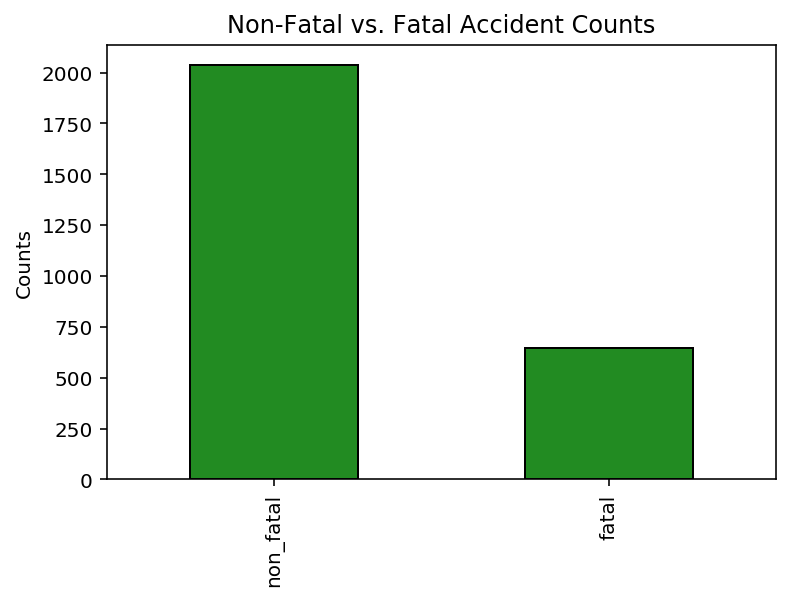

In [23]:
ax = df.fatalities.value_counts().plot(kind='bar', edgecolor='black', lw=1, color='forestgreen')
ax.set_ylabel('Counts')
_ = ax.set_title('Non-Fatal vs. Fatal Accident Counts')

It's not all that grim!

##  

## Looking at accidents that result in a fatality in the U.S compared to the rest of the world

In [24]:
len(df[(df['country'] != 'united_states') & (df['fatalities'] == 'fatal')])

314

In [25]:
len(df[(df['country'] != 'united_states') & (df['fatalities'] == 'non_fatal')])

150

In [26]:
len(df[(df['country'] == 'united_states') & (df['fatalities'] == 'fatal')])

334

In [27]:
len(df[(df['country'] == 'united_states') & (df['fatalities'] == 'non_fatal')])

1886

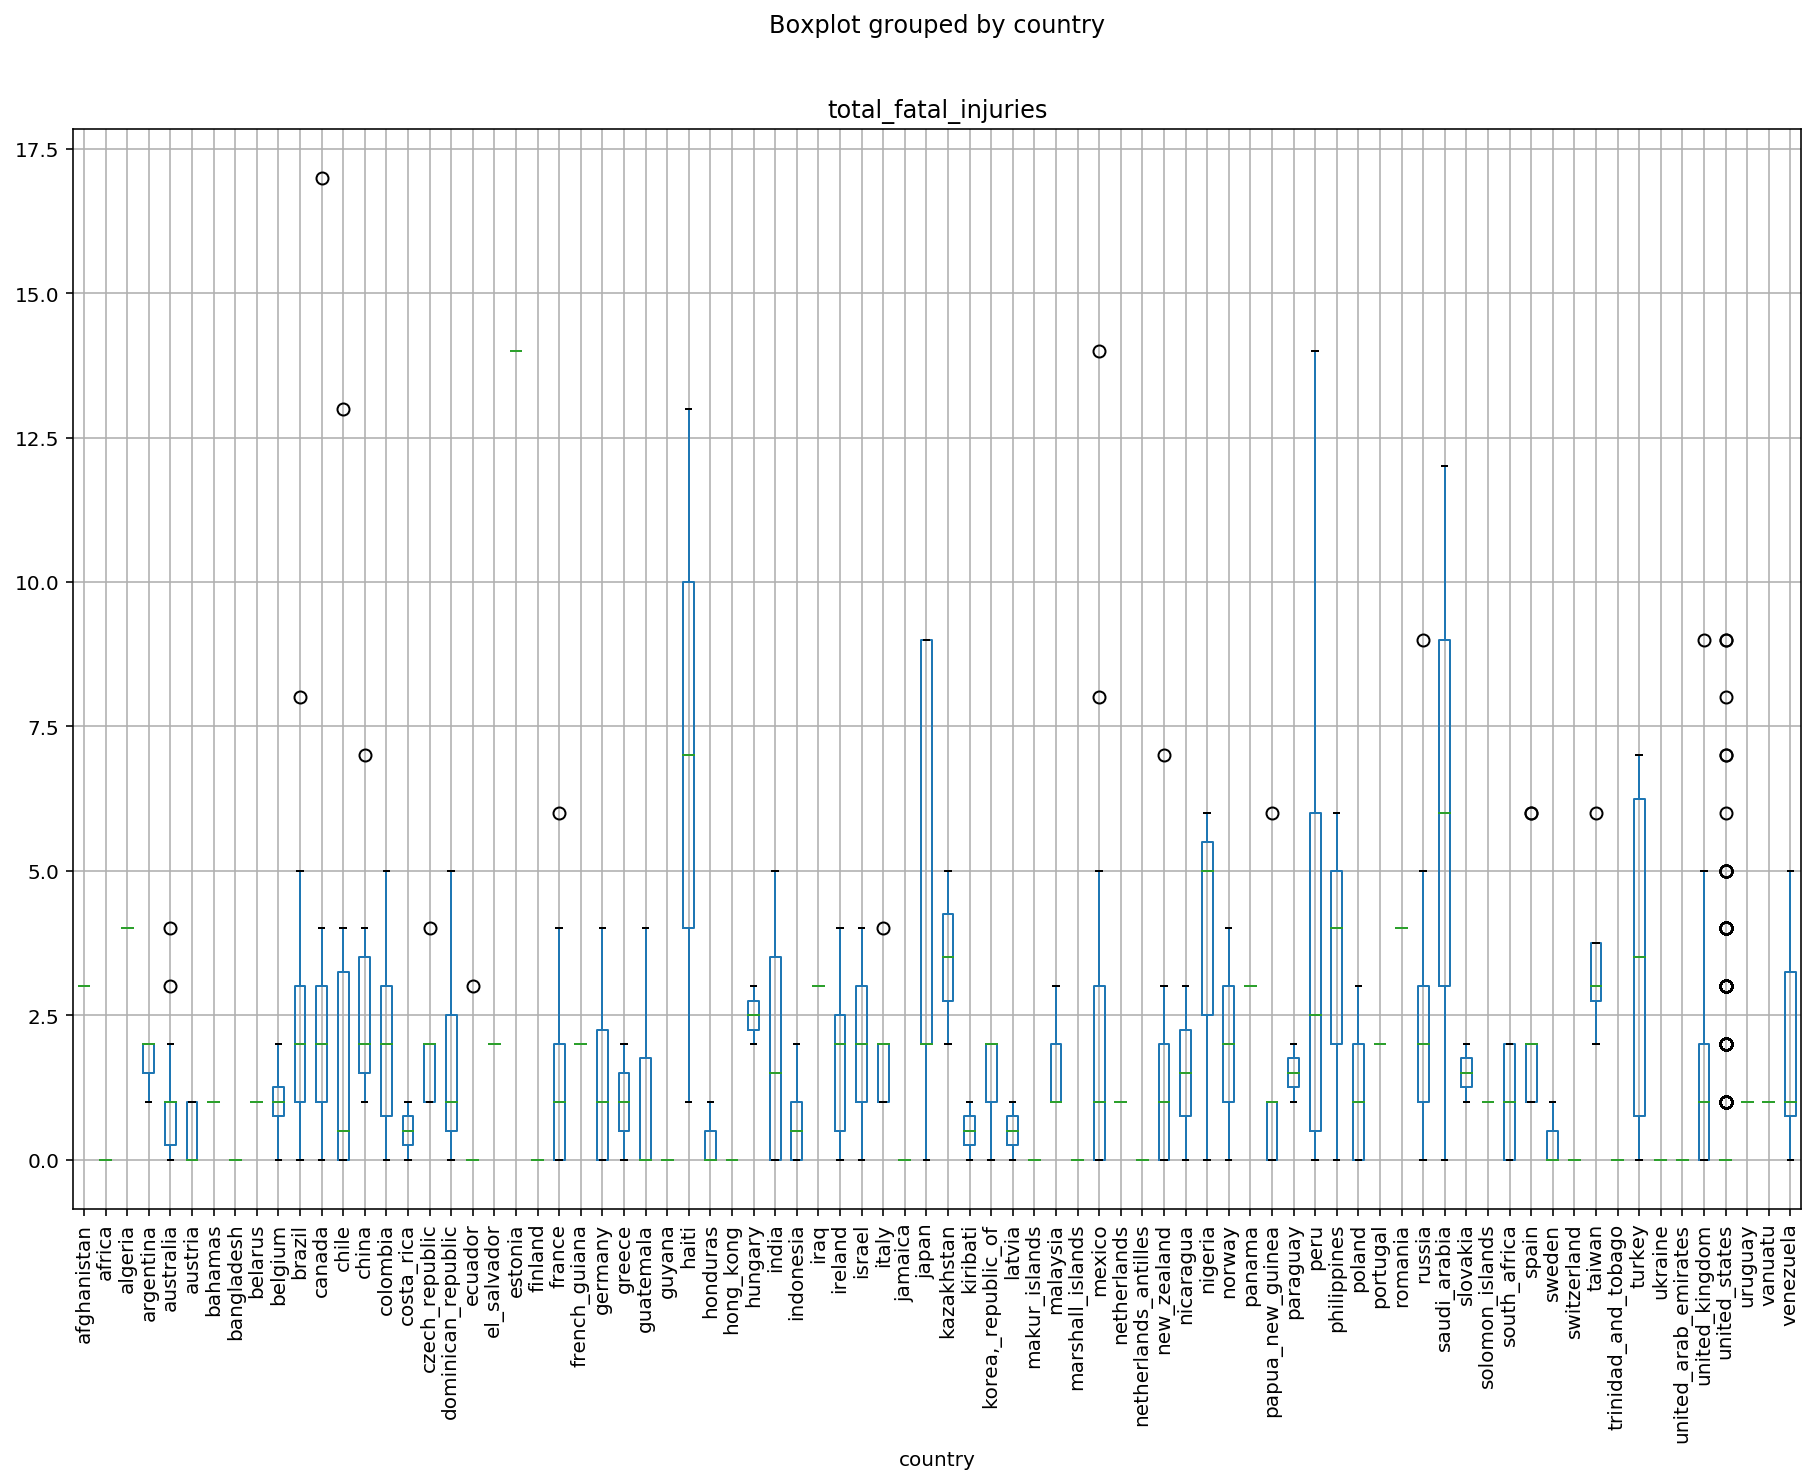

In [28]:
df.boxplot(column='total_fatal_injuries', by = 'country', rot= 90, figsize =(15,10));

The boxplot above shows an overall view of accidents that resulted in fatality from the dataset as is. It is a bit difficult to read given the number of countries, and the countries with greater counts pushing the "safer" countries down.

In [29]:
df_country=df[['country', 'total_fatal_injuries', 'total_serious_injuries', 'total_minor_injuries','total_uninjured','fatalities']]

In [30]:
df_country.head()

,country,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,fatalities
0,united_states,0.0,0.0,0.0,4.0,non_fatal
1,united_states,1.0,1.0,0.0,2.0,fatal
2,united_states,0.0,0.0,0.0,2.0,non_fatal
3,united_states,0.0,0.0,1.0,5.0,non_fatal
4,united_states,0.0,0.0,1.0,0.0,non_fatal


In [31]:
us=df_country[df_country.country == 'united_states']
us.head(2)

,country,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,fatalities
0,united_states,0.0,0.0,0.0,4.0,non_fatal
1,united_states,1.0,1.0,0.0,2.0,fatal


In [32]:
def US_or_not(x):
    
    if 'united_states' in x:
        return 'US'
    else:
        return 'Non_US'
    
    
df_country['us_or_not'] = df.country.map(US_or_not)
print(df_country['us_or_not'].unique())
print(df_country['us_or_not'].value_counts())    

['US' 'Non_US']
US        2220
Non_US    464 
Name: us_or_not, dtype: int64


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [33]:
def fatalities_binary(x):
    if 'non_fatal' in x:
        return 0
    else:
        return 1
    
df_country['fatal_or_not'] = df_country.fatalities.map(fatalities_binary)
print(df_country['fatal_or_not'].unique())
print(df_country['fatal_or_not'].value_counts()) 

[0 1]
0    2036
1    648 
Name: fatal_or_not, dtype: int64


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


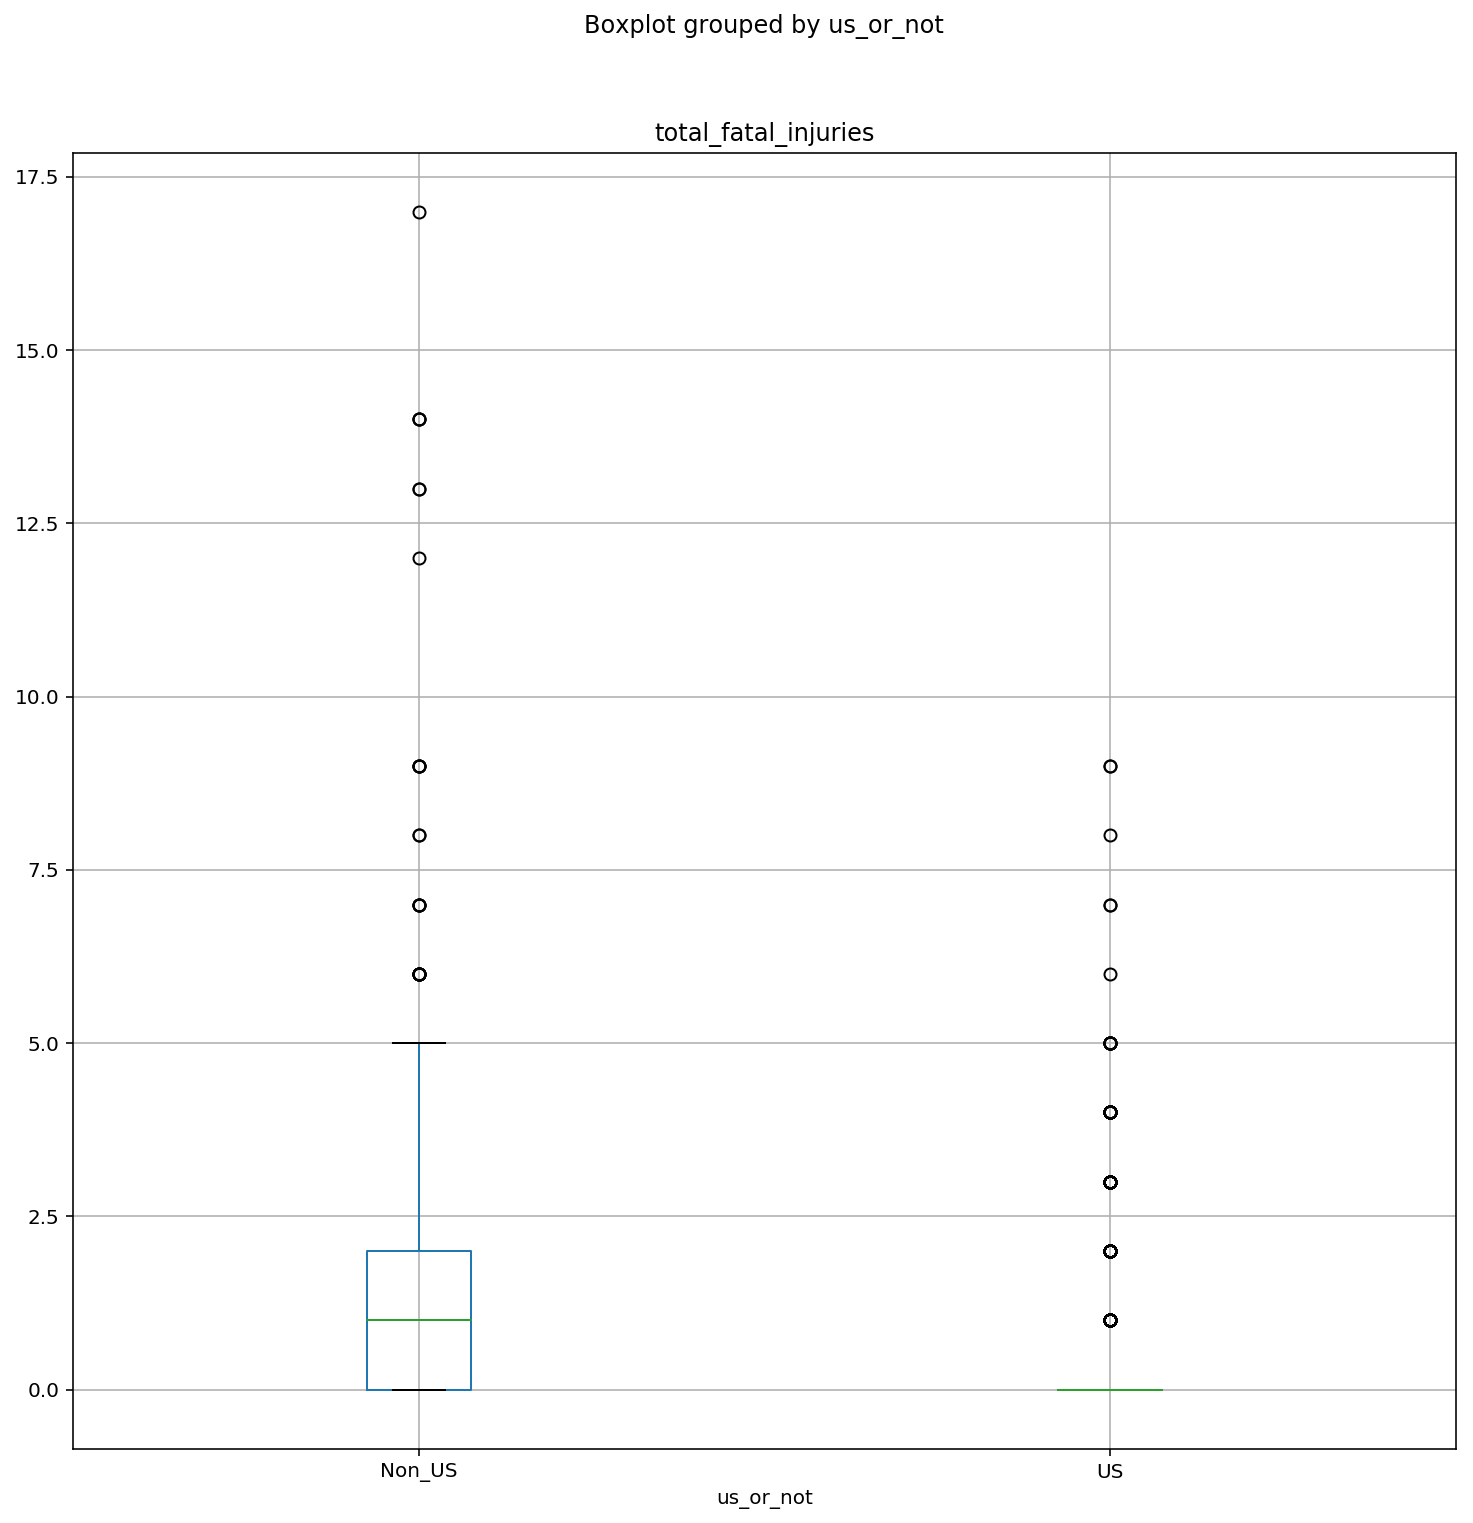

In [34]:
df_country.boxplot(column='total_fatal_injuries', by = 'us_or_not', figsize =(12,12));


The boxplot shows that the counts of accidents resulting in at least fatality. The majority of U.S accidents do not result in a fatality (mean sitting on zero) 
whereas the Non_U.S countries records show around 50% of accidents result in a fatality. 

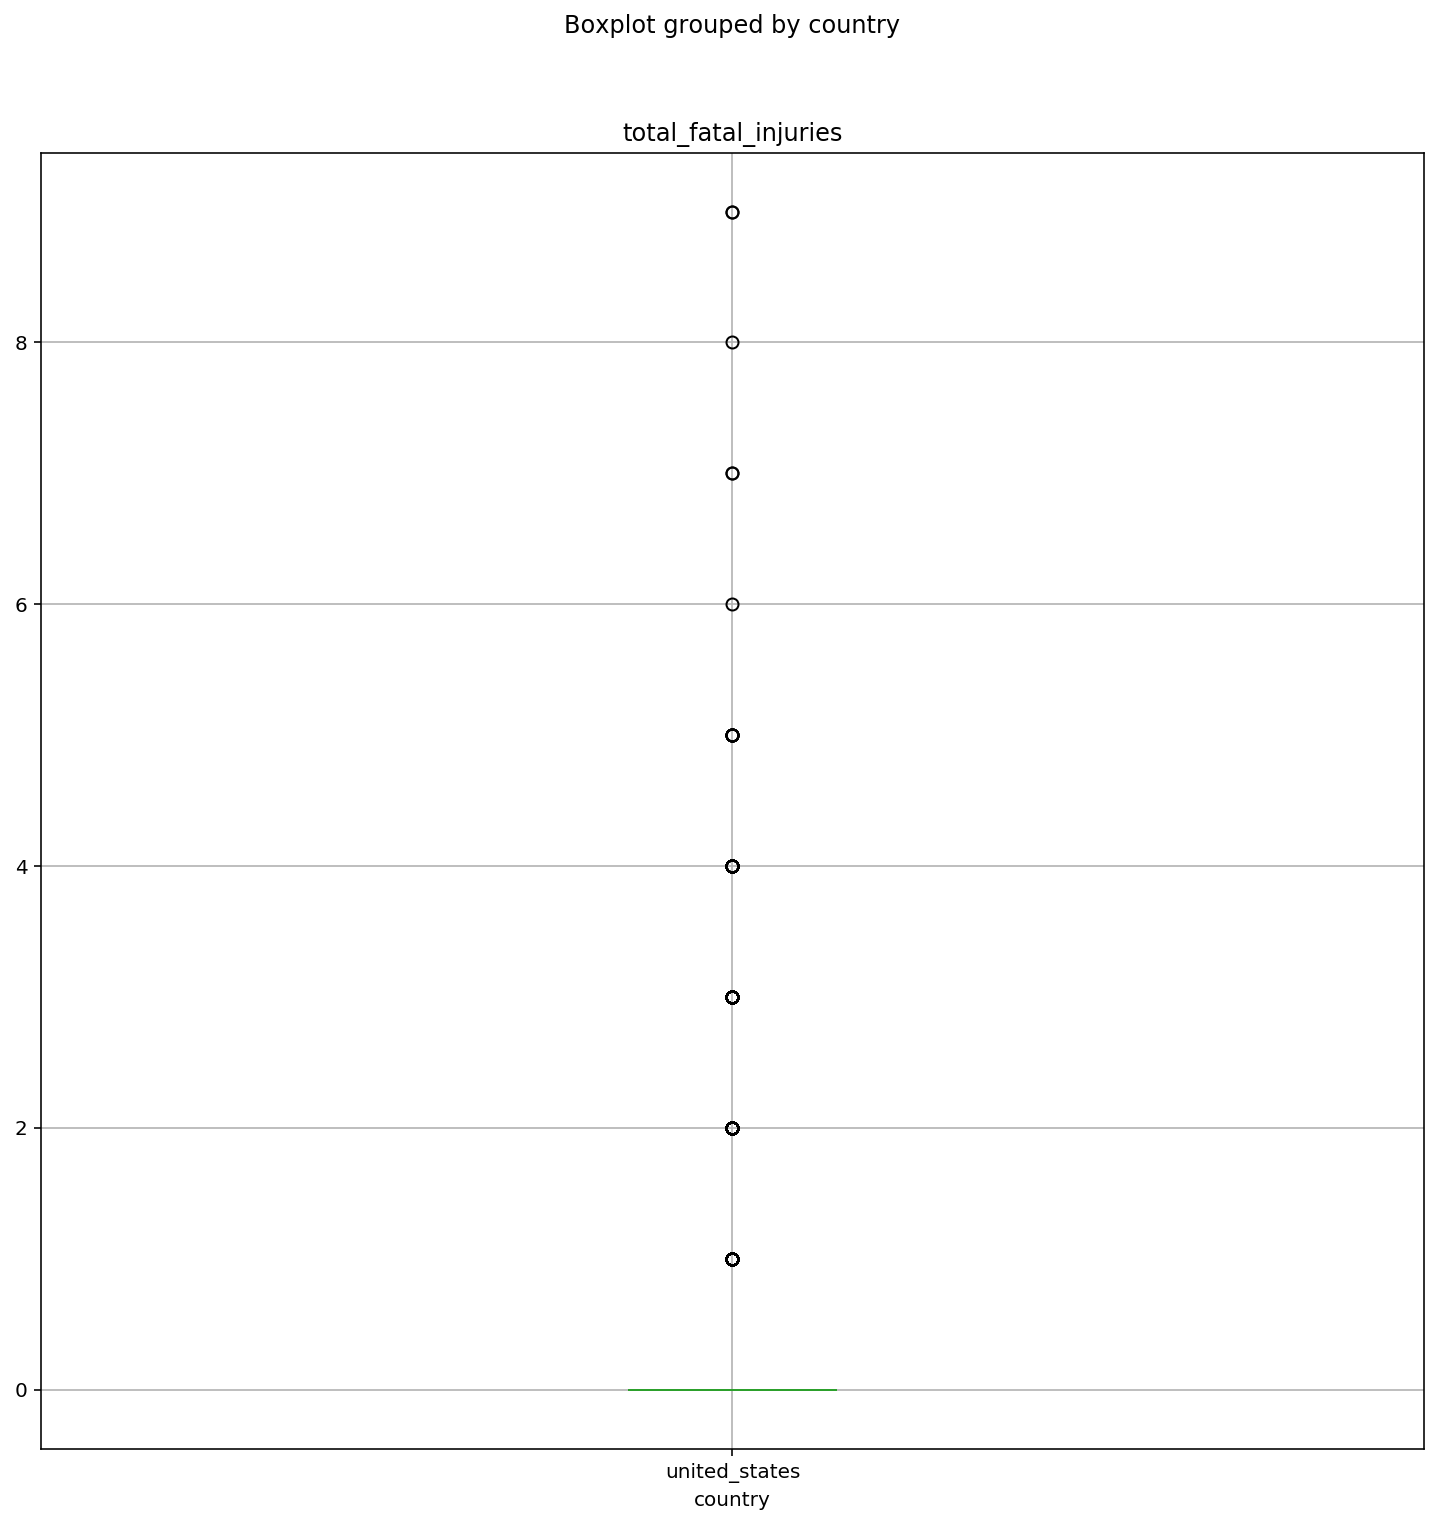

In [35]:
us.boxplot(column='total_fatal_injuries', by = 'country', figsize =(12,12));

Deciding to remove rest of the world from the dataset and to refine my project question to 'Surviving a Helicopter Accident in the U.S'
Decision to remove the rest of the world is based on:
Proportions of fatalities vs non-fatalities between the US and the rest of the world and the presence of rest of the world skewing the results.
Domain expertise - Knowledge of UK accidents. The UK data within the dataset, is not a complete (fatal and non-fatal). Assumption is that other countries data within the dataset will also be incomplete therefore skewing the data and giving a false result.

I have a visual in Tableau that shows the spread of locations of the dataset.

##  Making a dataframe that only includes U.S accidents

In [36]:
us_df=df[(df['country']== 'united_states')]

In [37]:
us_df.aircraft_damage.value_counts(0)

substantial    1930
destroyed      266 
unknown        15  
minor          9   
Name: aircraft_damage, dtype: int64

In [38]:
len(us_df[(us_df['aircraft_damage'] != 'destroyed') & (us_df['fatalities'] == 'fatal')])

179

In [39]:
len(us_df[(us_df['aircraft_damage'] != 'substantial') & (us_df['fatalities'] == 'fatal')])

168

In [40]:
us_df.to_csv('/Users/bronwyn/desktop/GA_Lessons/DSI8-lessons/projects/project-capstone/us_df_without_index.csv', index=False)


In [41]:
us_df.corr()

,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,people_on_board,latitude,longitude,month,no_of_engines1
total_fatal_injuries,1.000000,0.065051,-0.103586,-0.261653,0.334569,-0.032036,0.008684,0.025524,0.160446
total_serious_injuries,0.065051,1.000000,0.024054,-0.272791,0.221418,-0.032188,0.015923,-0.007191,0.020837
total_minor_injuries,-0.103586,0.024054,1.000000,-0.268935,0.287406,-0.037867,-0.023067,0.054251,0.025866
total_uninjured,-0.261653,-0.272791,-0.268935,1.000000,0.533341,-0.028726,-0.022674,-0.049345,0.150657
people_on_board,0.334569,0.221418,0.287406,0.533341,1.000000,-0.084925,-0.023792,-0.002601,0.272174
latitude,-0.032036,-0.032188,-0.037867,-0.028726,-0.084925,1.000000,-0.233113,0.014692,-0.015514
longitude,0.008684,0.015923,-0.023067,-0.022674,-0.023792,-0.233113,1.000000,0.033807,0.048568
month,0.025524,-0.007191,0.054251,-0.049345,-0.002601,0.014692,0.033807,1.000000,0.020928
no_of_engines1,0.160446,0.020837,0.025866,0.150657,0.272174,-0.015514,0.048568,0.020928,1.000000


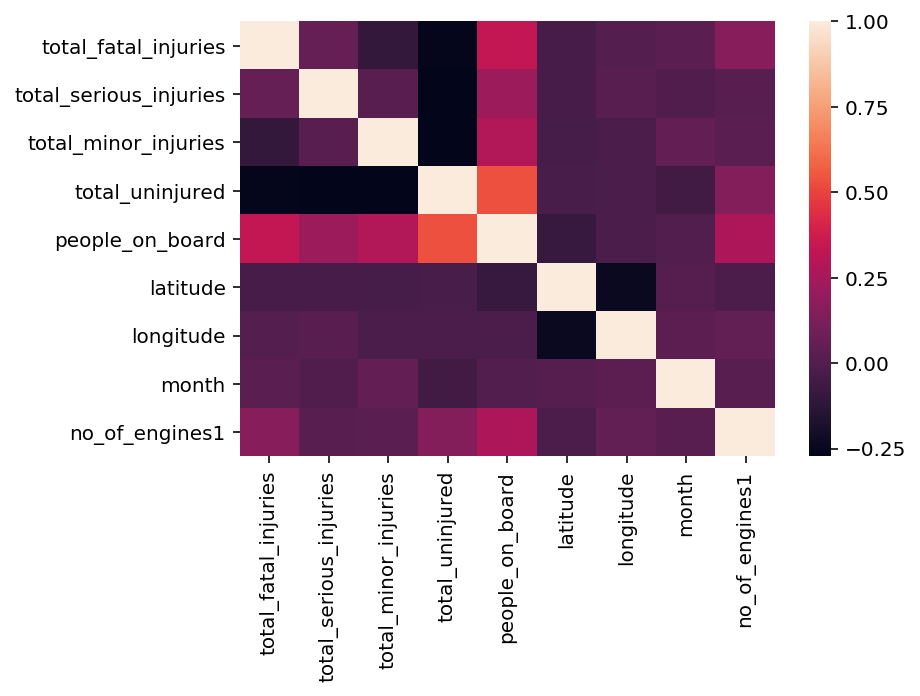

In [42]:
sns.heatmap(us_df.corr());

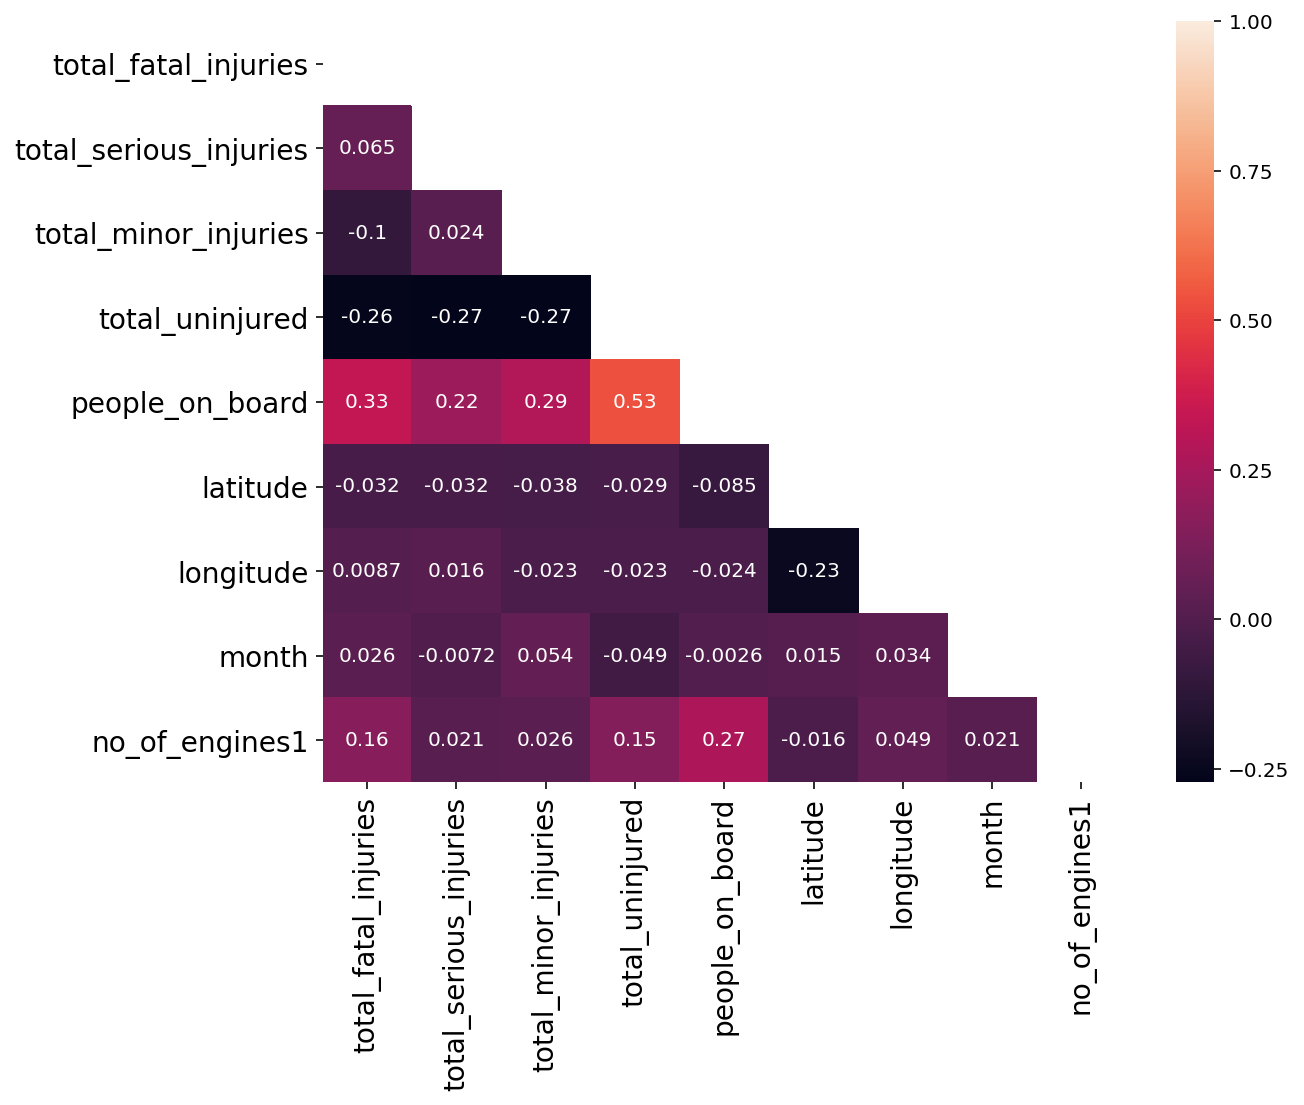

In [43]:
# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(9, 7))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(us_df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(us_df.corr(), mask=mask, annot=True, ax=ax)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

The strongest positive correlation is between people on board, and total uninjured.

##  Visualising the correlation of people on board vs total_uninjured

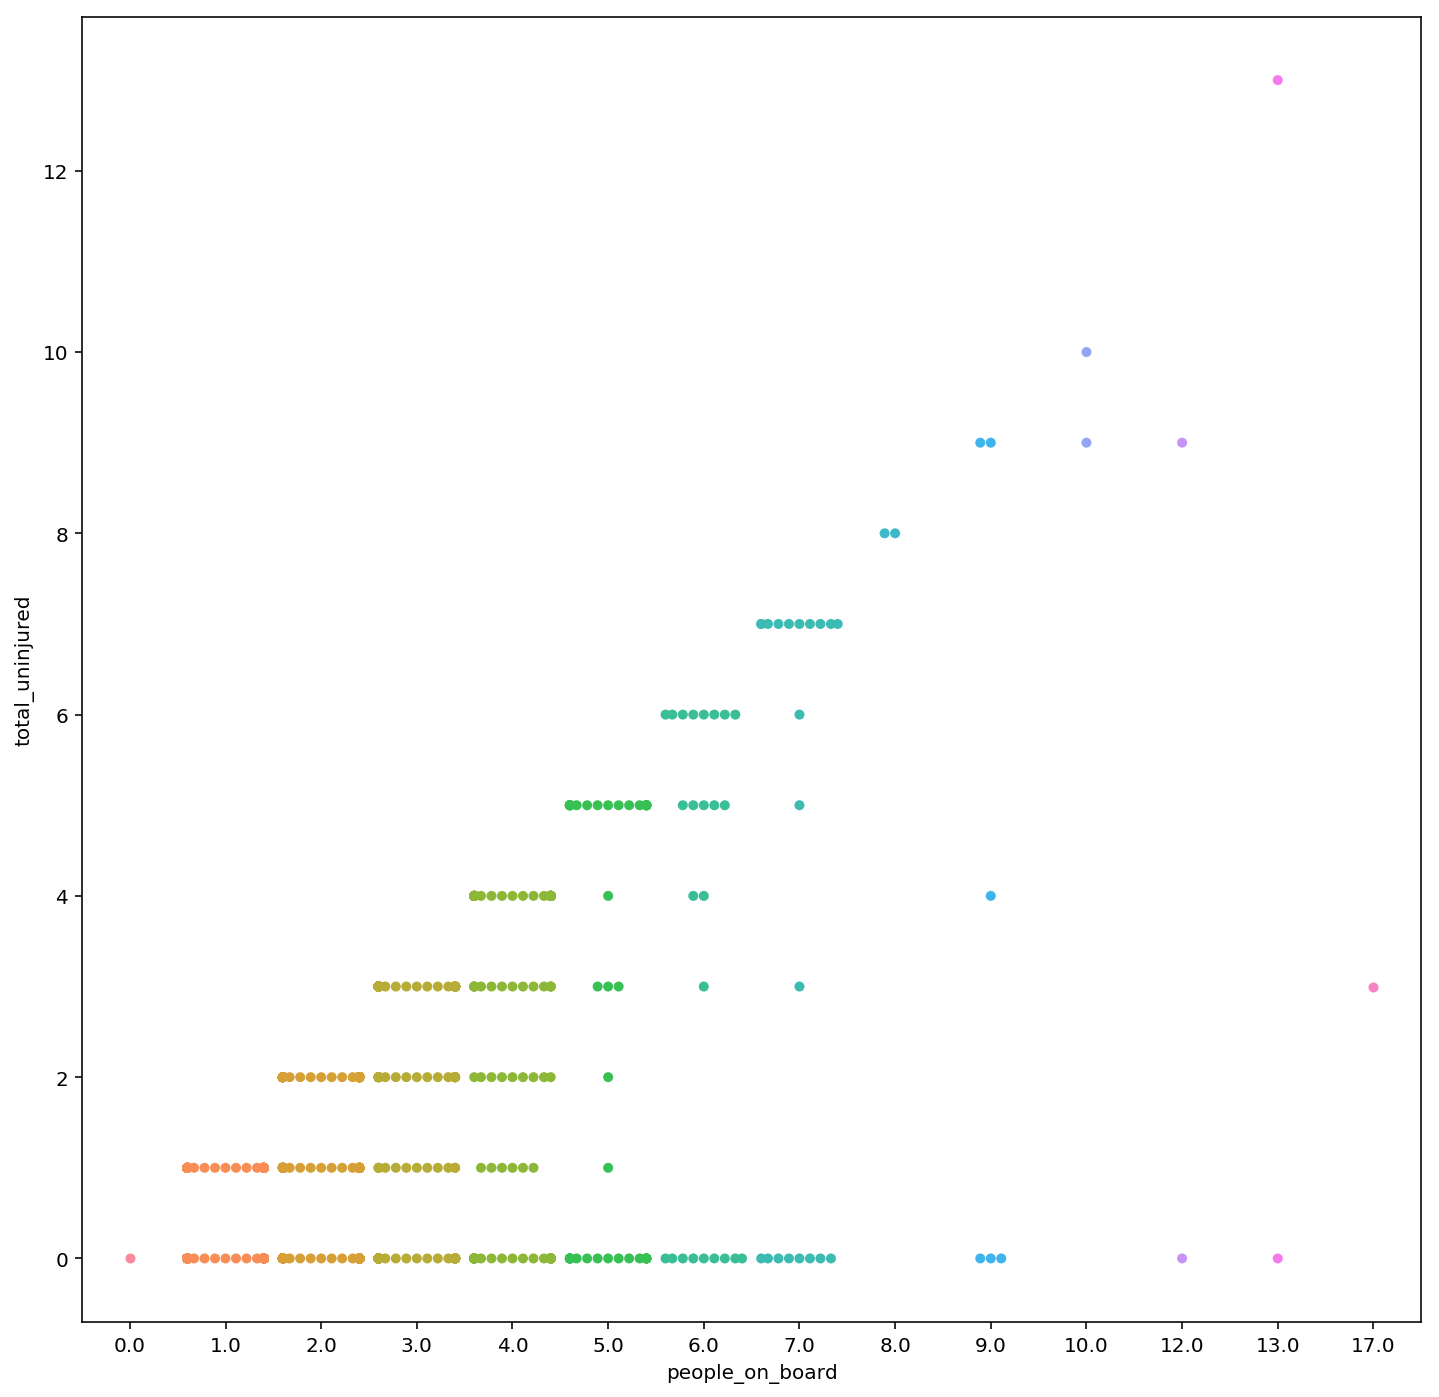

In [44]:
fig,ax = plt.subplots(figsize=(12,12))

sns.swarmplot(us_df['people_on_board'],us_df['total_uninjured'])

plt.show()

In [45]:
us_df.people_on_board.value_counts()

1.0     875
2.0     840
3.0     264
4.0     133
5.0     46 
6.0     25 
7.0     21 
9.0     6  
12.0    2  
13.0    2  
10.0    2  
8.0     2  
17.0    1  
0.0     1  
Name: people_on_board, dtype: int64

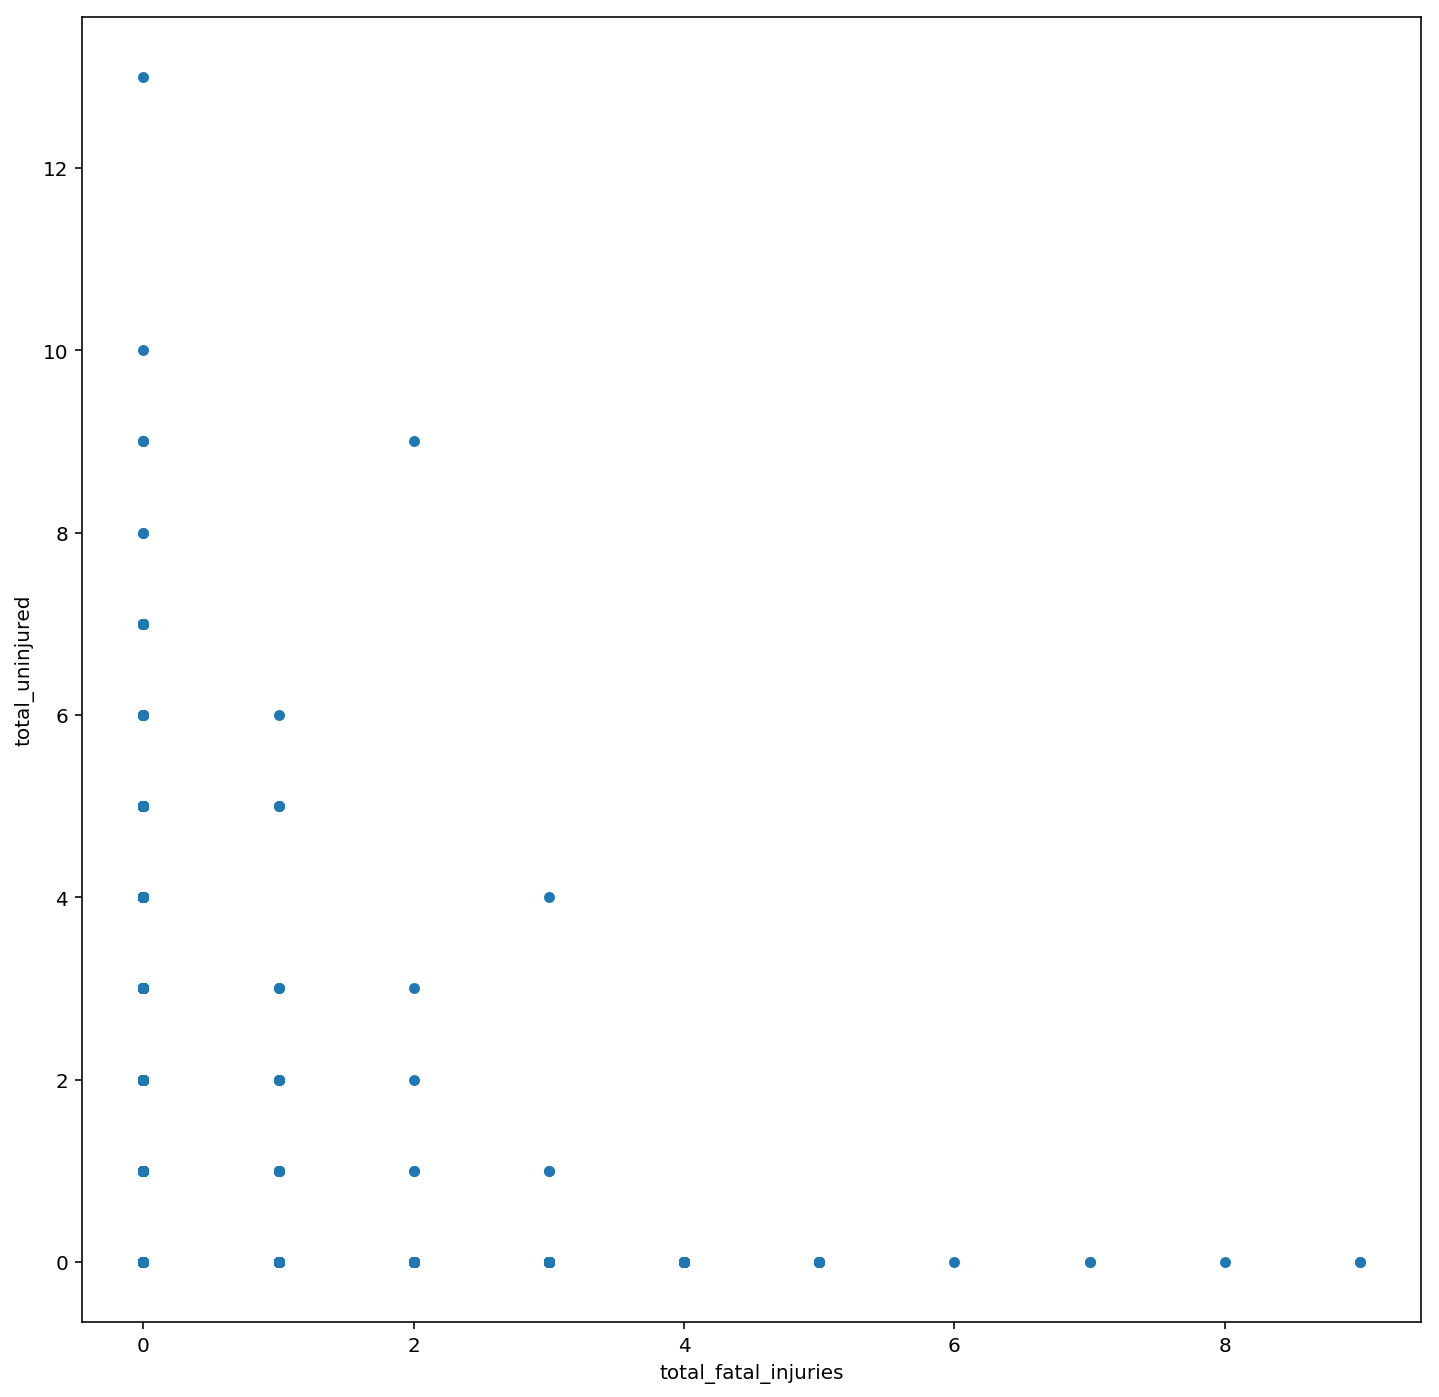

In [44]:
us_df.plot(kind='scatter', x= 'total_fatal_injuries', y='total_uninjured', figsize = (12,12));

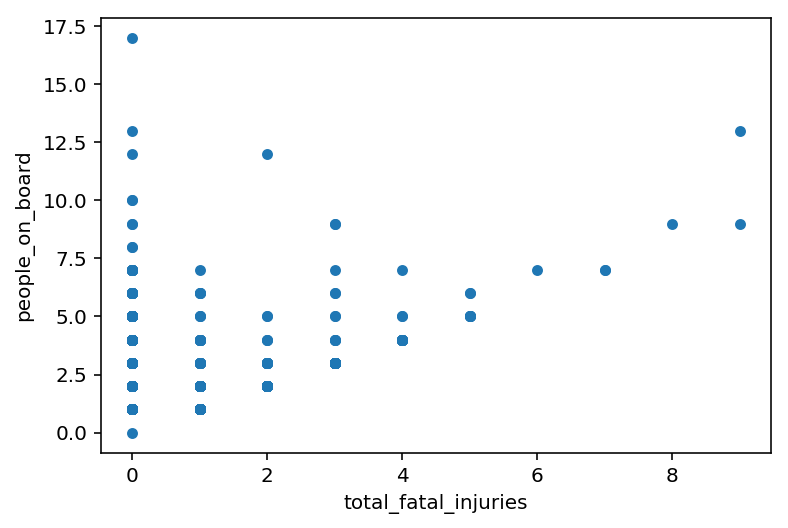

In [45]:
us_df.plot(kind='scatter', x= 'total_fatal_injuries', y='people_on_board');


##  Looking at type of pilot 

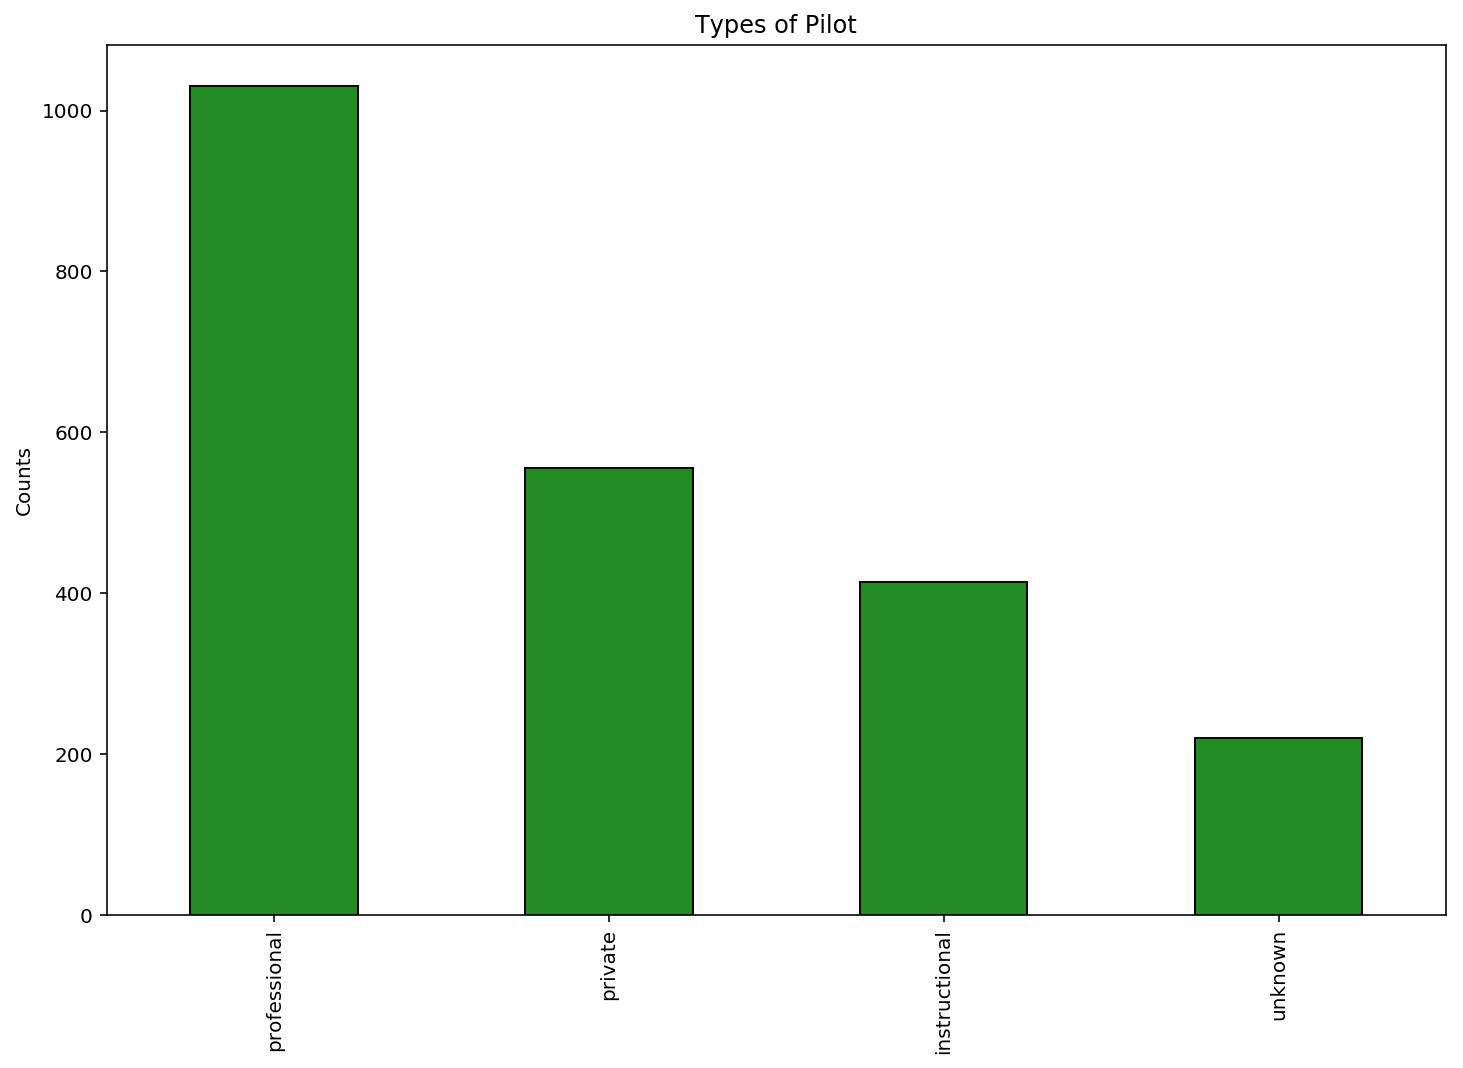

In [46]:
fig,ax = plt.subplots(figsize = [12, 8])
ax = us_df.pilot_type.value_counts().plot(kind='bar', edgecolor='black', lw=1, color='forestgreen')
ax.set_ylabel('Counts')
_ = ax.set_title('Types of Pilot')

In [47]:
pilot=us_df[['pilot_type', 'total_fatal_injuries', 'total_serious_injuries', 'total_minor_injuries', 'total_uninjured']]

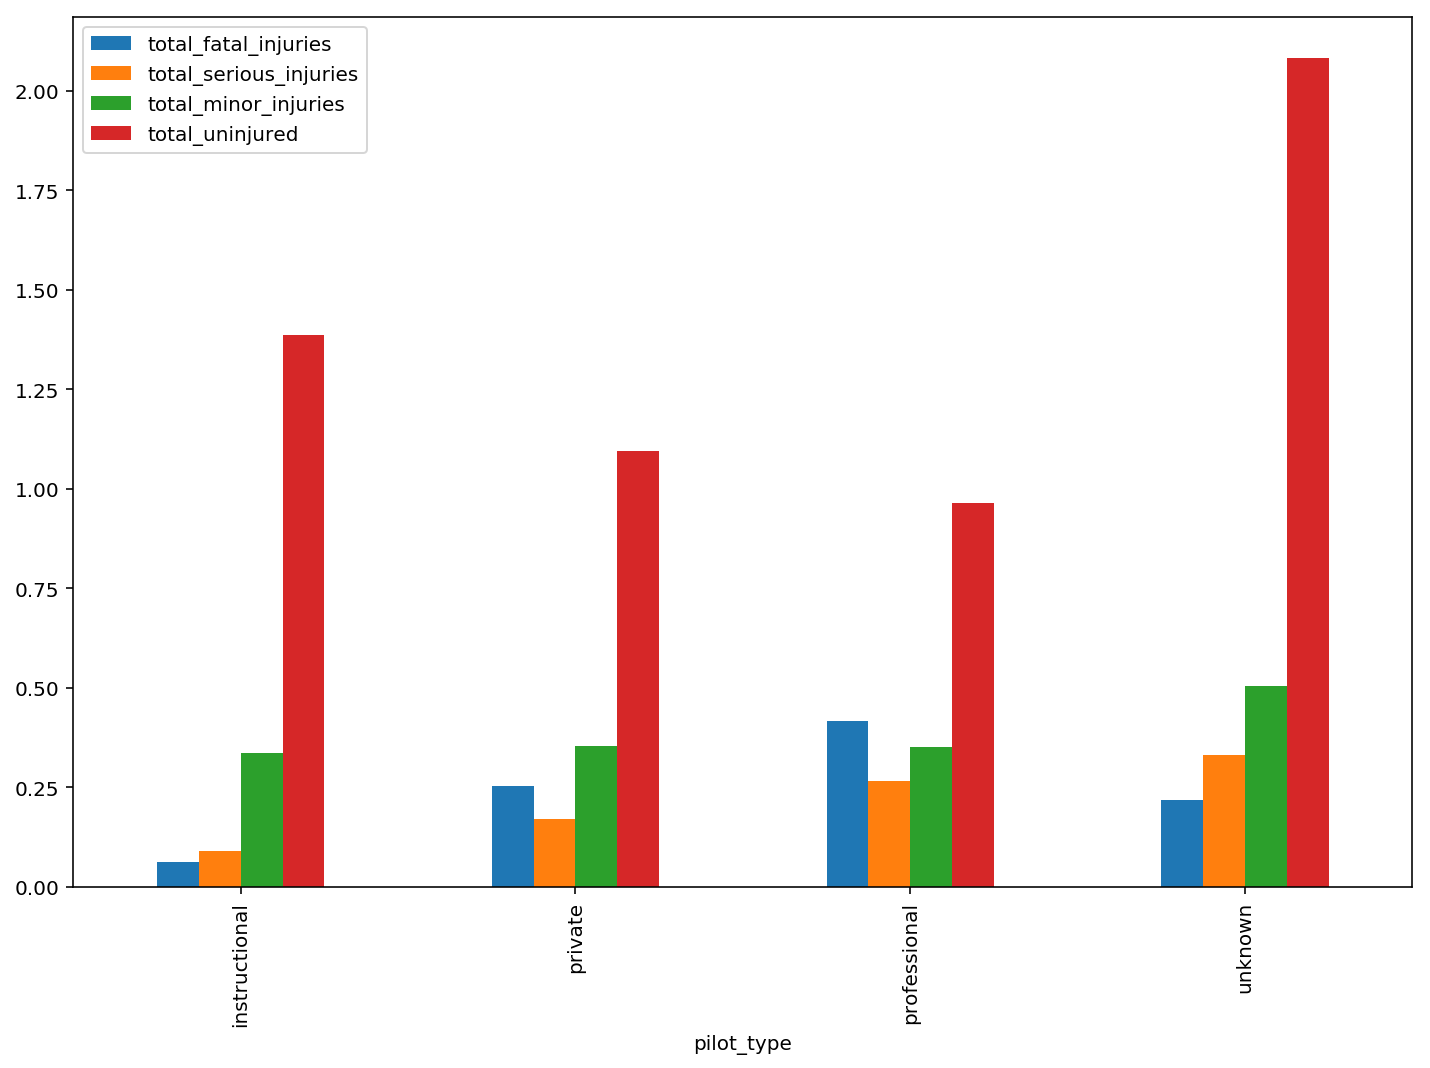

In [48]:
pilot.groupby('pilot_type').mean().plot(kind='bar', figsize=(12,8));

I've kept the catagory of 'unknown' pilot types in my dataset as not to drop rows, although for this plot dropping it as it does not add value. Note that the pilot type column was a made up column using the purpose of flight column. 
Personal or private purpose of flight = private
Instructional = Instructional
Unknown = Unknown
All others (which will be pilots who fly for a career) = professional

The reason for the generation of this column is due to the assumption that a professional pilot will have received training to a higher level than a private pilot, and will have more experience.



In [49]:
8

8

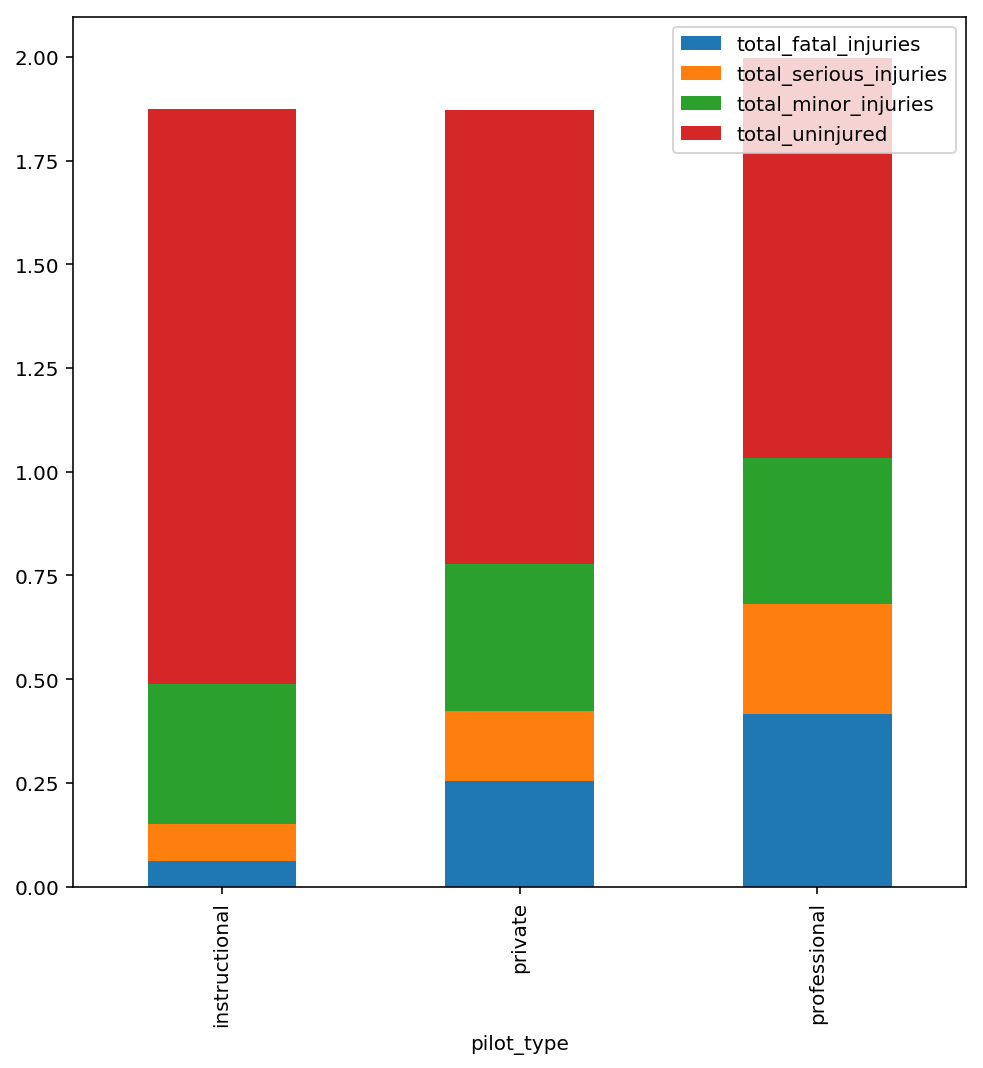

In [50]:
pilot.groupby('pilot_type').mean().drop('unknown', axis=0).plot(kind='bar', stacked = True, figsize = (8,8));

In [51]:
pilot.groupby('pilot_type').total_fatal_injuries.describe()

,count,mean,std,min,25%,50%,75%,max
pilot_type,,,,,,,,
instructional,414.0,0.062802,0.320287,0.0,0.0,0.0,0.0,3.0
private,556.0,0.253597,0.693915,0.0,0.0,0.0,0.0,5.0
professional,1030.0,0.416505,1.049929,0.0,0.0,0.0,0.0,9.0
unknown,220.0,0.218182,0.809553,0.0,0.0,0.0,0.0,7.0


##  

##  Now taking a closer look at instructional flights

Instructional is an interesting subset as this includes flights with instructor and student, as well as just students because students are technically unlicensed and fly on the instructors licence when flying solo.

In [52]:
len(us_df[(us_df['pilot_type'] == 'instructional') & (us_df['fatalities'] == 'fatal')&(us_df['people_on_board']==1)])

7

In [53]:
len(us_df[(us_df['pilot_type'] == 'instructional') & (us_df['fatalities'] == 'fatal')&(us_df['people_on_board']==2)])

10

In [54]:
len(us_df[(us_df['pilot_type'] == 'instructional') & (us_df['fatalities'] != 'fatal')&(us_df['people_on_board']==1)])

65

In [55]:
len(us_df[(us_df['pilot_type'] == 'instructional') & (us_df['fatalities'] != 'fatal')&(us_df['people_on_board']==2)])

318

It looks like 7 students have died from an accident while flying solo

##  

In [56]:
i_df=us_df[(us_df['pilot_type']== 'instructional')]

In [57]:
i_df.head()

,make,model,engine_type1,amateur_built,event_date,location,country,injury_severity,purpose_of_flight,weather_condition,broad_phase_of_flight,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,people_on_board,phase_of_flight,latitude,longitude,aircraft_damage,investigation_type,day_of_week,month,no_of_engines1,pilot_type,fatalities
2,robinson,r44,reciprocating,no,2019-04-02,"taunton,_ma",united_states,Non-Fatal,instructional,vmc,maneuvering,0.0,0.0,0.0,2.0,2.0,unknown,41.874445,-71.016389,substantial,accident,Tuesday,4,1,instructional,non_fatal
17,robinson,r22,reciprocating,no,2019-02-19,"clearwater,_fl",united_states,Non-Fatal,instructional,vmc,maneuvering,0.0,0.0,0.0,2.0,2.0,unknown,27.975834,-82.756389,substantial,accident,Tuesday,2,1,instructional,non_fatal
20,aerospatiale,as350,turbine,no,2019-01-29,"tampa,_fl",united_states,Non-Fatal,instructional,vmc,landing,0.0,0.0,0.0,2.0,2.0,unknown,28.011111,-82.344444,substantial,accident,Tuesday,1,1,instructional,non_fatal
22,bell,206,turbine,no,2019-01-23,"ashland,_or",united_states,Fatal(1),instructional,vmc,maneuvering,1.0,0.0,0.0,0.0,1.0,unknown,42.066667,-122.596389,substantial,accident,Wednesday,1,1,instructional,fatal
26,robinson,r44,reciprocating,no,2019-01-08,"uvalde,_tx",united_states,Non-Fatal,instructional,vmc,takeoff,0.0,0.0,1.0,1.0,2.0,unknown,29.210278,-99.743055,substantial,accident,Tuesday,1,1,instructional,non_fatal


In [58]:
instruct=i_df[['people_on_board', 'broad_phase_of_flight', 'total_fatal_injuries', 'total_serious_injuries', 'total_minor_injuries', 'total_uninjured']]


In [59]:
instruct.head()

,people_on_board,broad_phase_of_flight,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured
2,2.0,maneuvering,0.0,0.0,0.0,2.0
17,2.0,maneuvering,0.0,0.0,0.0,2.0
20,2.0,landing,0.0,0.0,0.0,2.0
22,1.0,maneuvering,1.0,0.0,0.0,0.0
26,2.0,takeoff,0.0,0.0,1.0,1.0


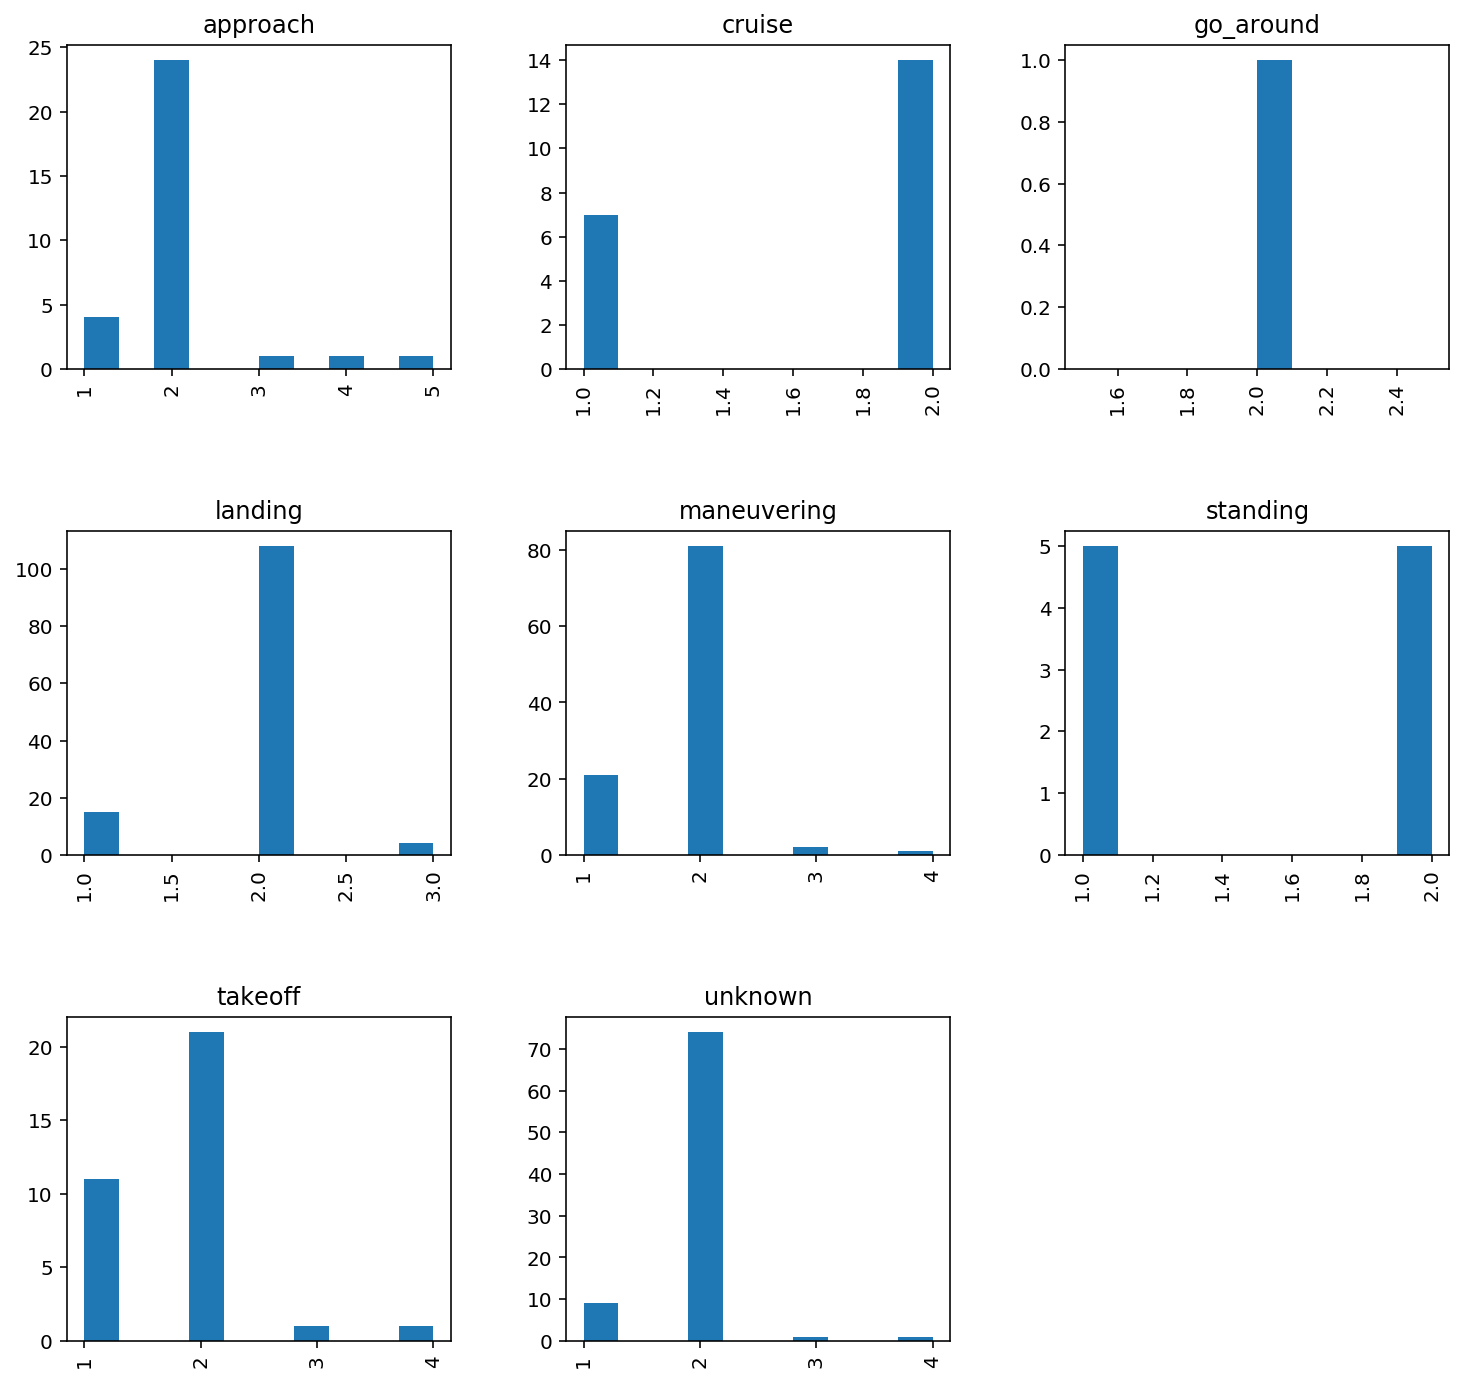

In [60]:
instruct.hist(column='people_on_board', by='broad_phase_of_flight',figsize=(12,12));

##  

In [61]:
instruct.columns

Index(['people_on_board', 'broad_phase_of_flight', 'total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured'],
      dtype='object')

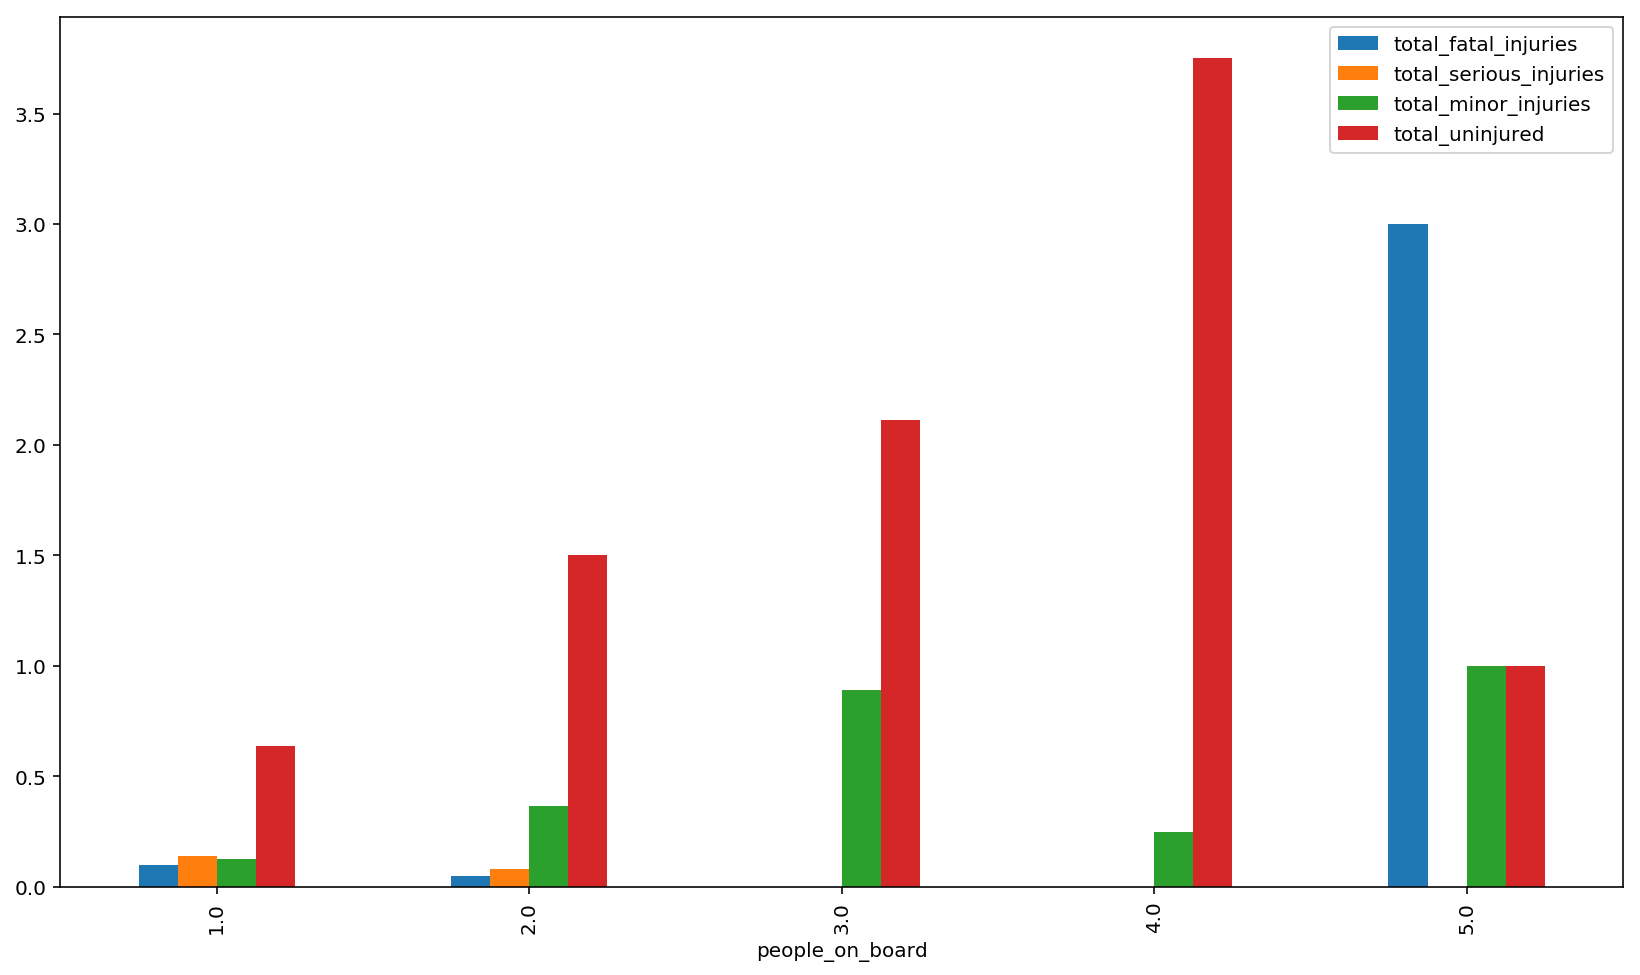

In [62]:
instruct.groupby(['people_on_board'])[ 'total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured'].mean().plot(kind='bar', figsize = (14,8));

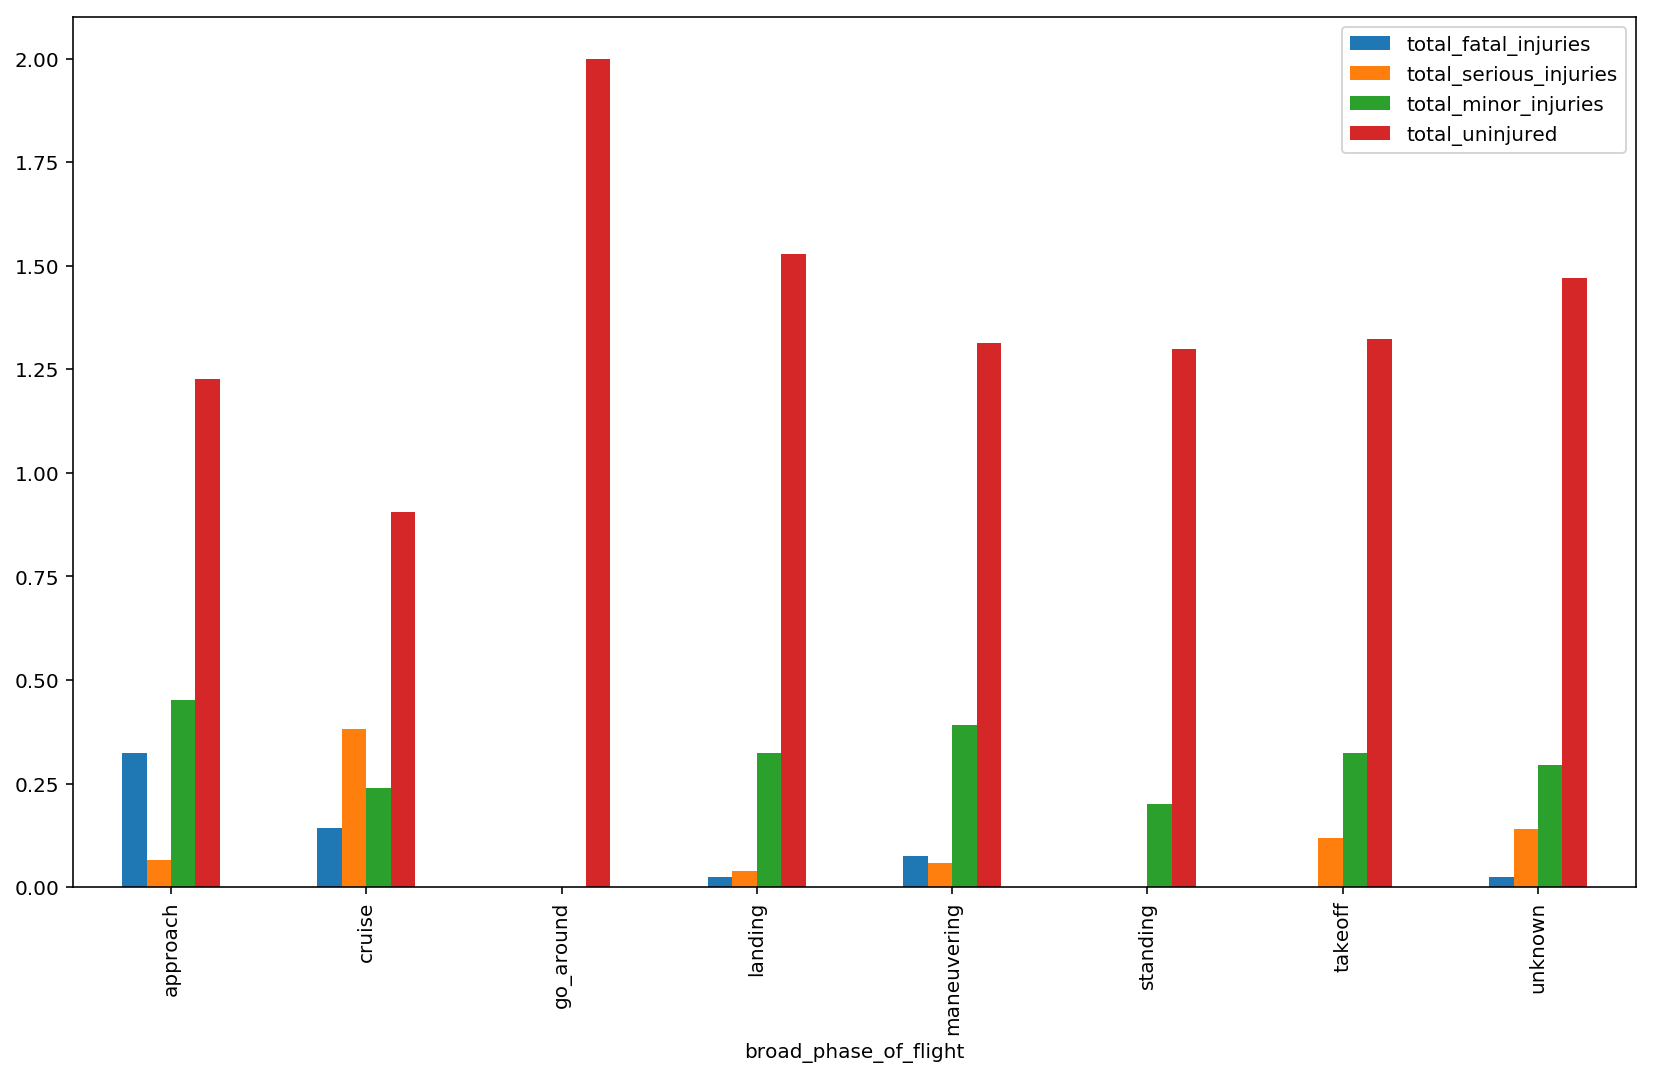

In [63]:
instruct.groupby(['broad_phase_of_flight'])[ 'total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured'].mean().plot(kind='bar', figsize = (14,8));

## Now looking at weather

A private helicopter pilot is taught to fly using visual references, and therefore must stay out of cloud where 
you can quickly loose your sense of direction, attitude. Within the dataset, fine weather is defined as VMC, and 
clouds/limited visibility is IMC. This is to investigate accidents where the pilot has ended up in IMC.

In [64]:
weather = us_df[['weather_condition','total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured']]

In [65]:
weather.head()

,weather_condition,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured
0,vmc,0.0,0.0,0.0,4.0
1,vmc,1.0,1.0,0.0,2.0
2,vmc,0.0,0.0,0.0,2.0
3,vmc,0.0,0.0,1.0,5.0
4,unknown,0.0,0.0,1.0,0.0


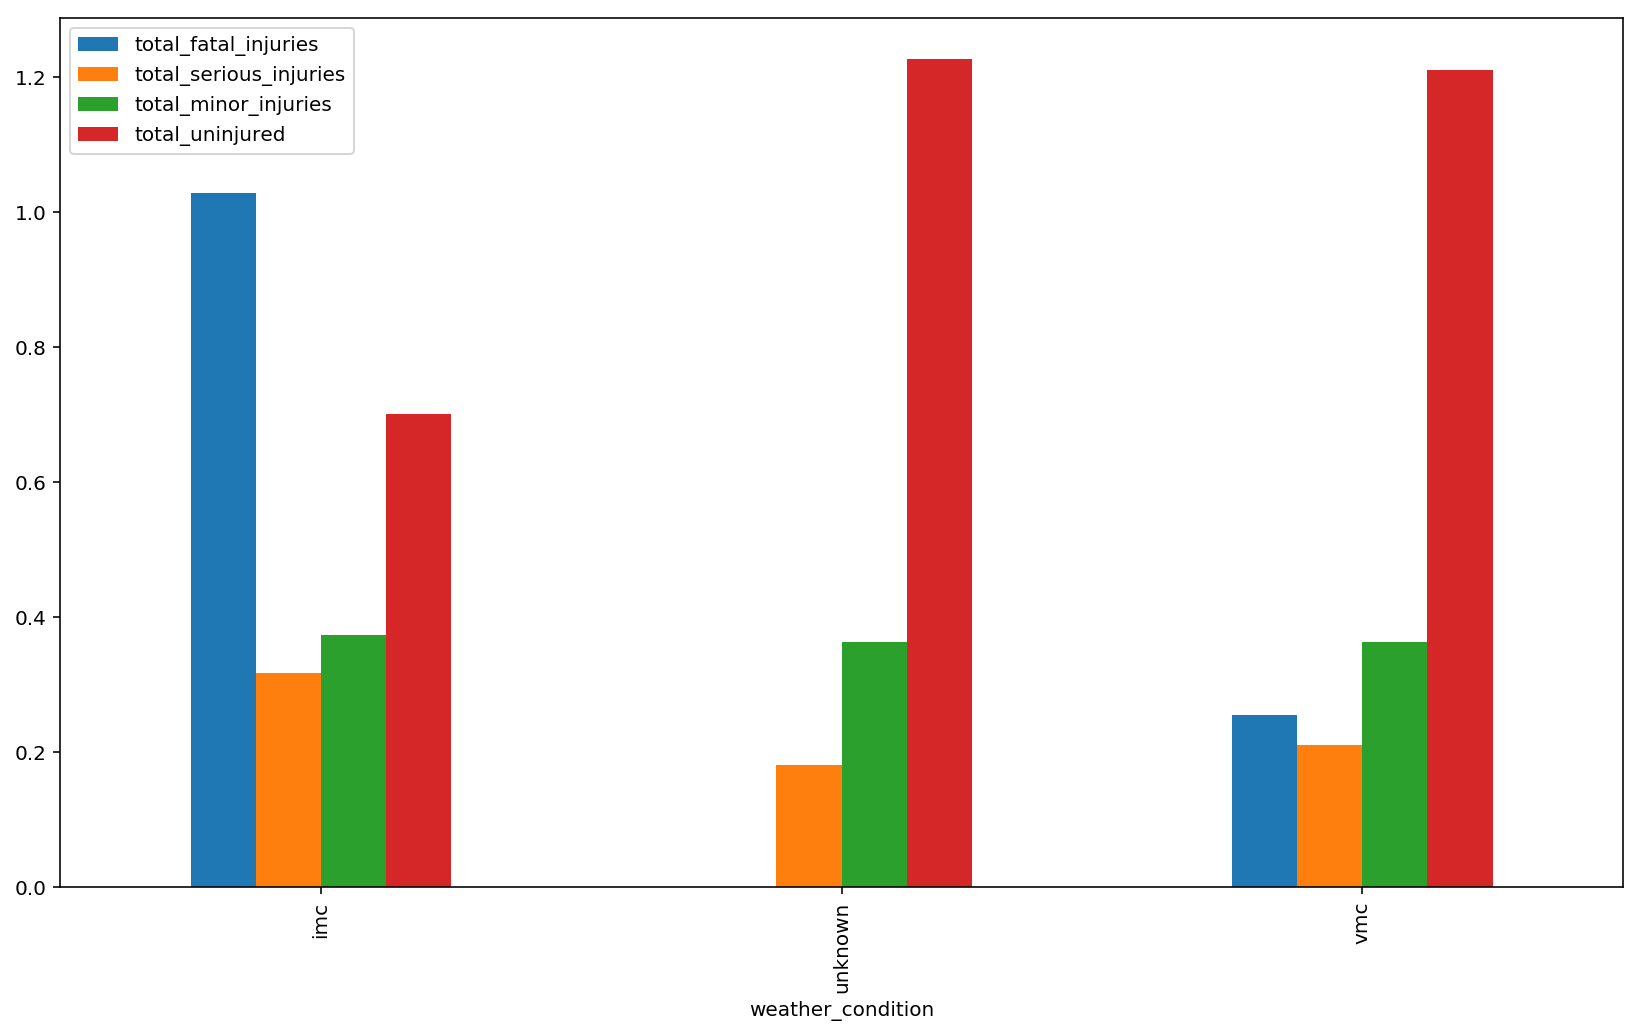

In [66]:
weather.groupby(['weather_condition'])[ 'total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured'].mean().plot(kind='bar', figsize = (14,8));

It looks like inadvertently ending up in IMC is as bad as it sounds

##  

## Does day of the week make a difference? 

In [67]:
dow = us_df[['day_of_week','total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured']]

In [68]:
dow.groupby('day_of_week').total_fatal_injuries.value_counts()

day_of_week  total_fatal_injuries
Friday       0.0                     315
             1.0                     29 
             2.0                     13 
             3.0                     8  
             4.0                     4  
             6.0                     1  
Monday       0.0                     238
             1.0                     24 
             2.0                     11 
             3.0                     6  
             4.0                     2  
             5.0                     1  
Saturday     0.0                     300
             1.0                     30 
             3.0                     12 
             2.0                     7  
             4.0                     3  
             5.0                     1  
             9.0                     1  
Sunday       0.0                     221
             1.0                     26 
             2.0                     7  
             3.0                     6  
             4.0       

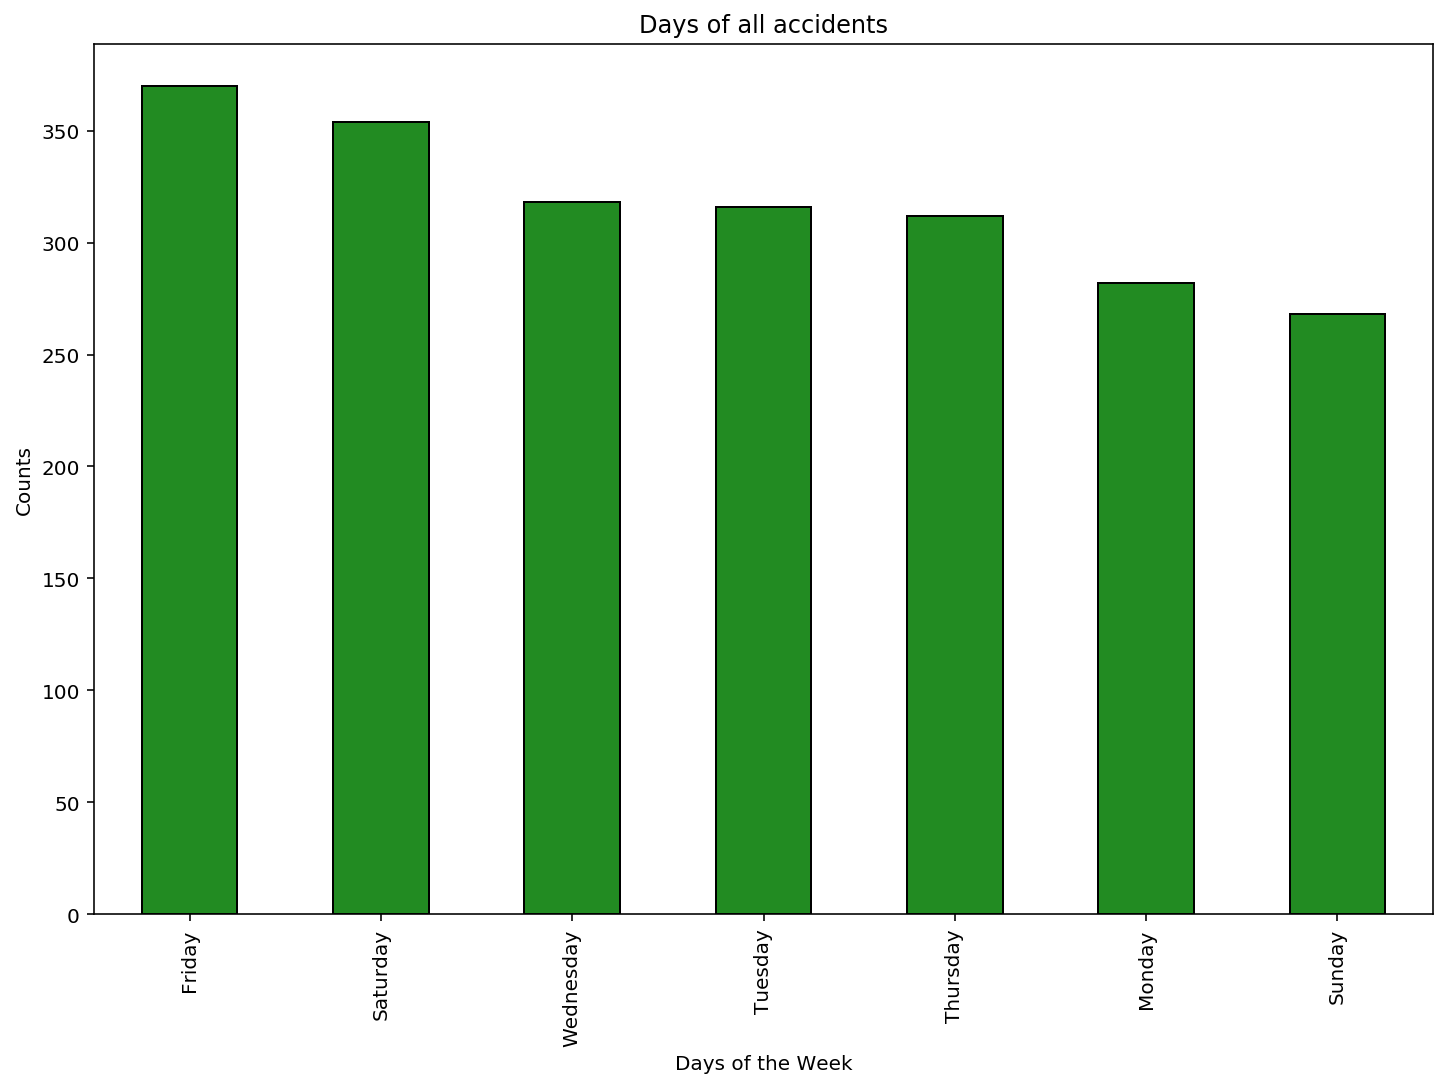

In [69]:
ax = us_df.day_of_week.value_counts().plot(kind='bar', edgecolor='black', lw=1, color='forestgreen', figsize = (12,8));
ax.set_ylabel('Counts')
_ = ax.set_title('Days of all accidents')
plt.xlabel('Days of the Week');

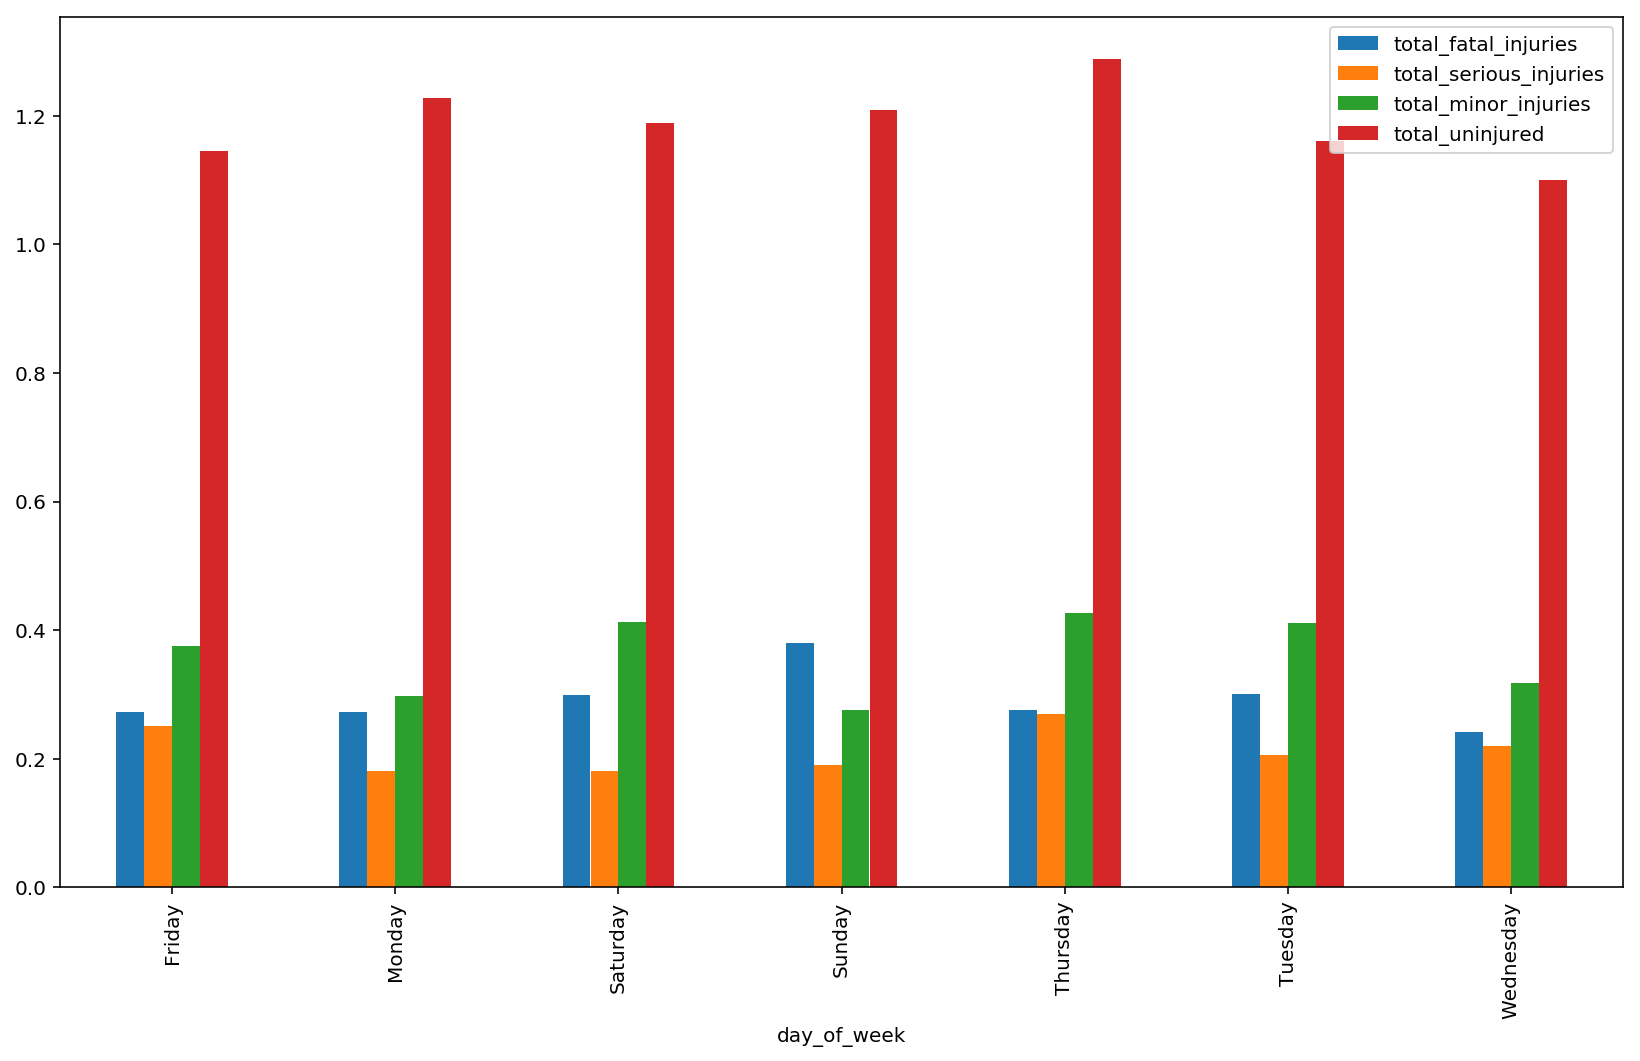

In [70]:
dow.groupby(['day_of_week'])[ 'total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured'].mean().plot(kind='bar', figsize = (14,8));

Looking to see if there is a time when private pilots are more likely to have an accident

In [71]:
us_df.head()

,make,model,engine_type1,amateur_built,event_date,location,country,injury_severity,purpose_of_flight,weather_condition,broad_phase_of_flight,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,people_on_board,phase_of_flight,latitude,longitude,aircraft_damage,investigation_type,day_of_week,month,no_of_engines1,pilot_type,fatalities
0,hughes,369,turbine,no,2019-04-16,"hauula,_hi",united_states,Non-Fatal,business,vmc,cruise,0.0,0.0,0.0,4.0,4.0,unknown,21.588333,-157.911944,substantial,accident,Tuesday,4,1,professional,non_fatal
1,robinson,r44,reciprocating,no,2019-04-04,"tampa,_fl",united_states,Fatal(1),private,vmc,cruise,1.0,1.0,0.0,2.0,4.0,unknown,27.943333,-82.401944,substantial,accident,Thursday,4,1,private,fatal
2,robinson,r44,reciprocating,no,2019-04-02,"taunton,_ma",united_states,Non-Fatal,instructional,vmc,maneuvering,0.0,0.0,0.0,2.0,2.0,unknown,41.874445,-71.016389,substantial,accident,Tuesday,4,1,instructional,non_fatal
3,bell,222,turbine,no,2019-03-30,"montgomery,_ny",united_states,Non-Fatal,private,vmc,takeoff,0.0,0.0,1.0,5.0,6.0,unknown,41.539444,-74.306944,substantial,accident,Saturday,3,2,private,non_fatal
4,bell,206,turbine,no,2019-03-29,"valley_center,_ca",united_states,Non-Fatal,survey,unknown,unknown,0.0,0.0,1.0,0.0,1.0,unknown,33.218370,-117.034197,substantial,accident,Friday,3,1,professional,non_fatal


In [72]:
private=us_df[us_df['pilot_type']=='private']

In [73]:
private.head()

,make,model,engine_type1,amateur_built,event_date,location,country,injury_severity,purpose_of_flight,weather_condition,broad_phase_of_flight,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,people_on_board,phase_of_flight,latitude,longitude,aircraft_damage,investigation_type,day_of_week,month,no_of_engines1,pilot_type,fatalities
1,robinson,r44,reciprocating,no,2019-04-04,"tampa,_fl",united_states,Fatal(1),private,vmc,cruise,1.0,1.0,0.0,2.0,4.0,unknown,27.943333,-82.401944,substantial,accident,Thursday,4,1,private,fatal
3,bell,222,turbine,no,2019-03-30,"montgomery,_ny",united_states,Non-Fatal,private,vmc,takeoff,0.0,0.0,1.0,5.0,6.0,unknown,41.539444,-74.306944,substantial,accident,Saturday,3,2,private,non_fatal
6,robinson,r22,reciprocating,no,2019-03-20,"madill,_ok",united_states,Non-Fatal,private,vmc,cruise,0.0,0.0,0.0,1.0,1.0,unknown,34.090375,-96.771669,substantial,accident,Wednesday,3,1,private,non_fatal
7,hughes,369,turbine,no,2019-03-17,"newberg,_or",united_states,Non-Fatal,private,vmc,cruise,0.0,0.0,0.0,2.0,2.0,unknown,45.300596,-122.972542,substantial,accident,Sunday,3,1,private,non_fatal
8,hughes,h500,turbine,no,2019-03-13,"keene,_nh",united_states,Non-Fatal,private,vmc,cruise,0.0,0.0,0.0,1.0,1.0,unknown,42.898333,-72.270834,substantial,accident,Wednesday,3,1,private,non_fatal


In [74]:
pplh=private[['day_of_week','total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured' ]]

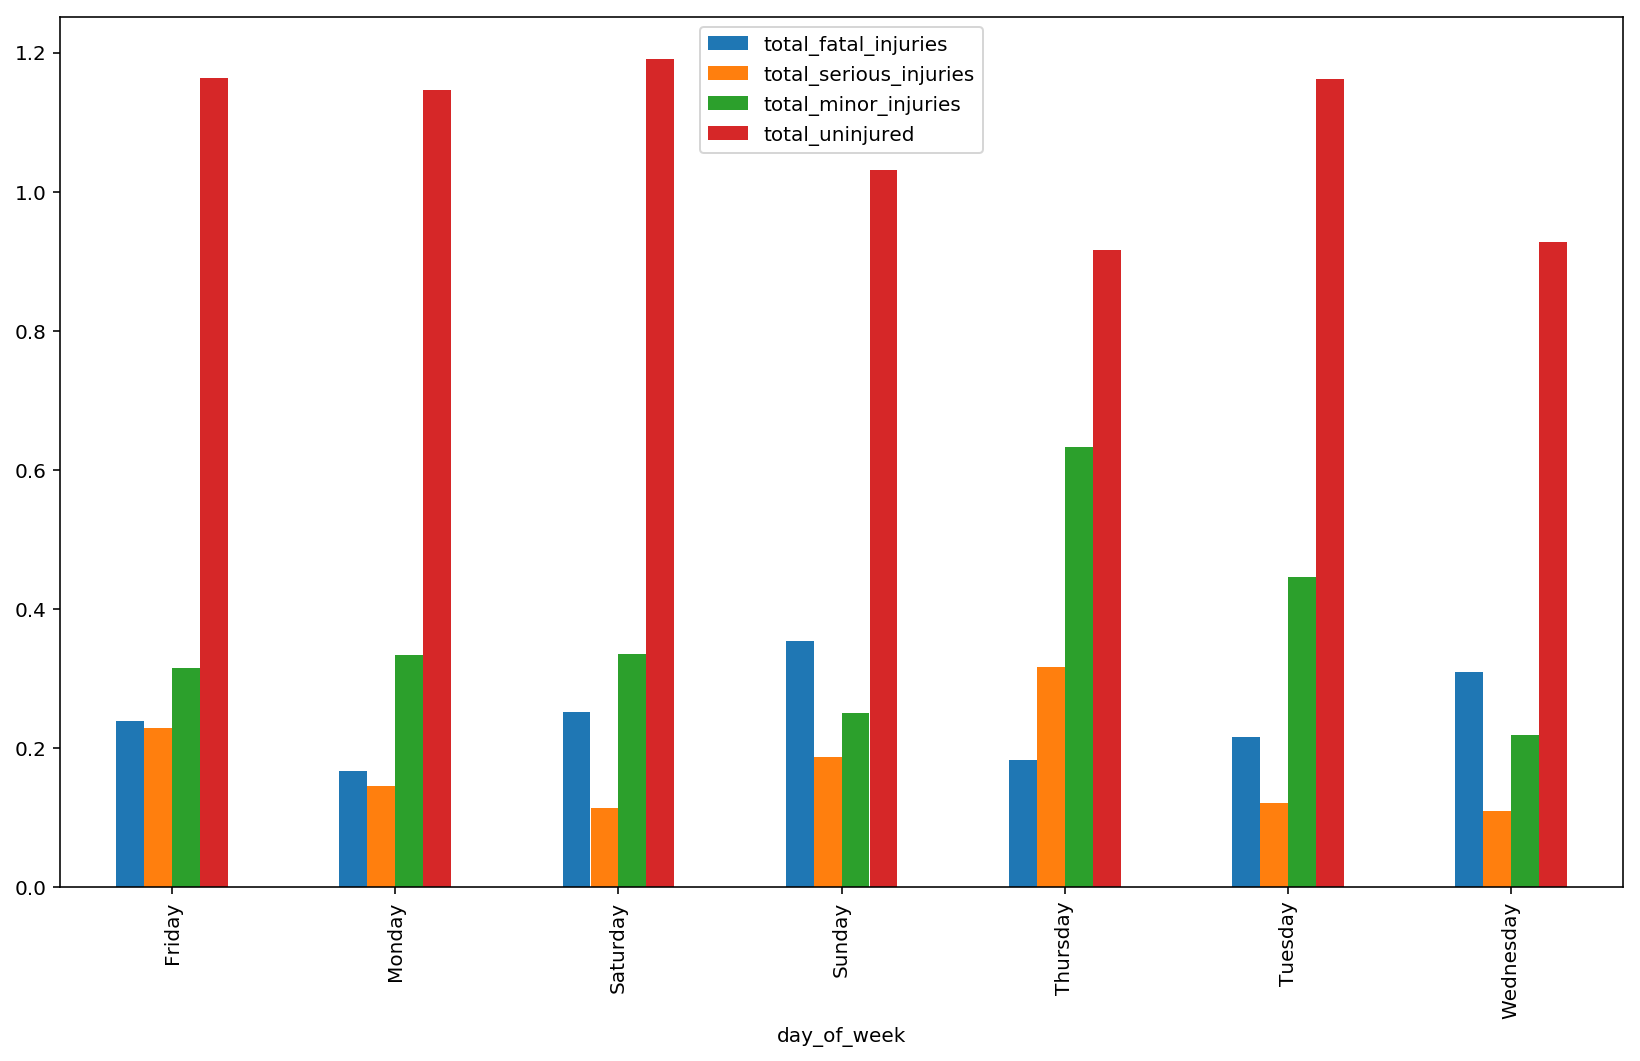

In [75]:
pplh.groupby(['day_of_week'])[ 'total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured'].mean().plot(kind='bar', figsize = (14,8));

It looks like a Sunday is the worse day to fly with a private pilot

Also wondering about if there is anything to be seen with private pilots safety and seasons. 
Google says the American winter starts at the end of December, and that seasons are felt from about latitude 40N

In [76]:
season=us_df[(us_df['latitude']>40) & (us_df['pilot_type']=='private')]

In [77]:
season.latitude.head()

3     41.539444
7     45.300596
8     42.898333
27    42.461944
31    42.768889
Name: latitude, dtype: float64

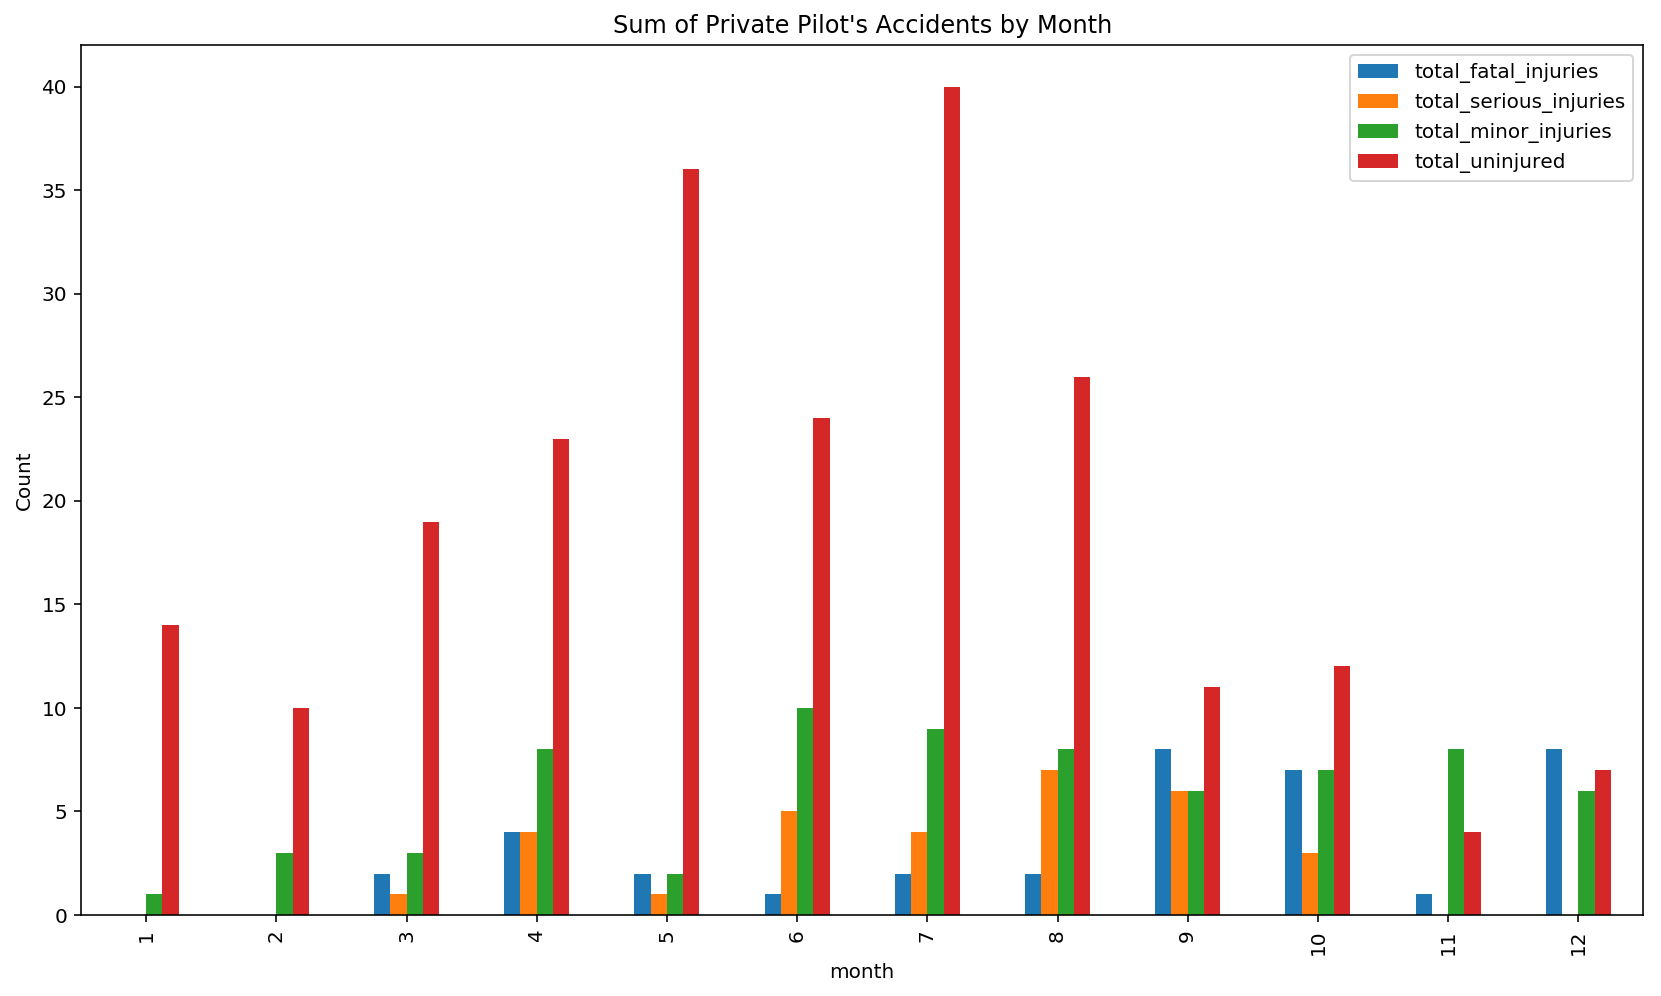

In [78]:
season.groupby(['month'])['total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured'].sum().plot(kind='bar', figsize = (14,8))
plt.ylabel('Count')
plt.title("Sum of Private Pilot's Accidents by Month");

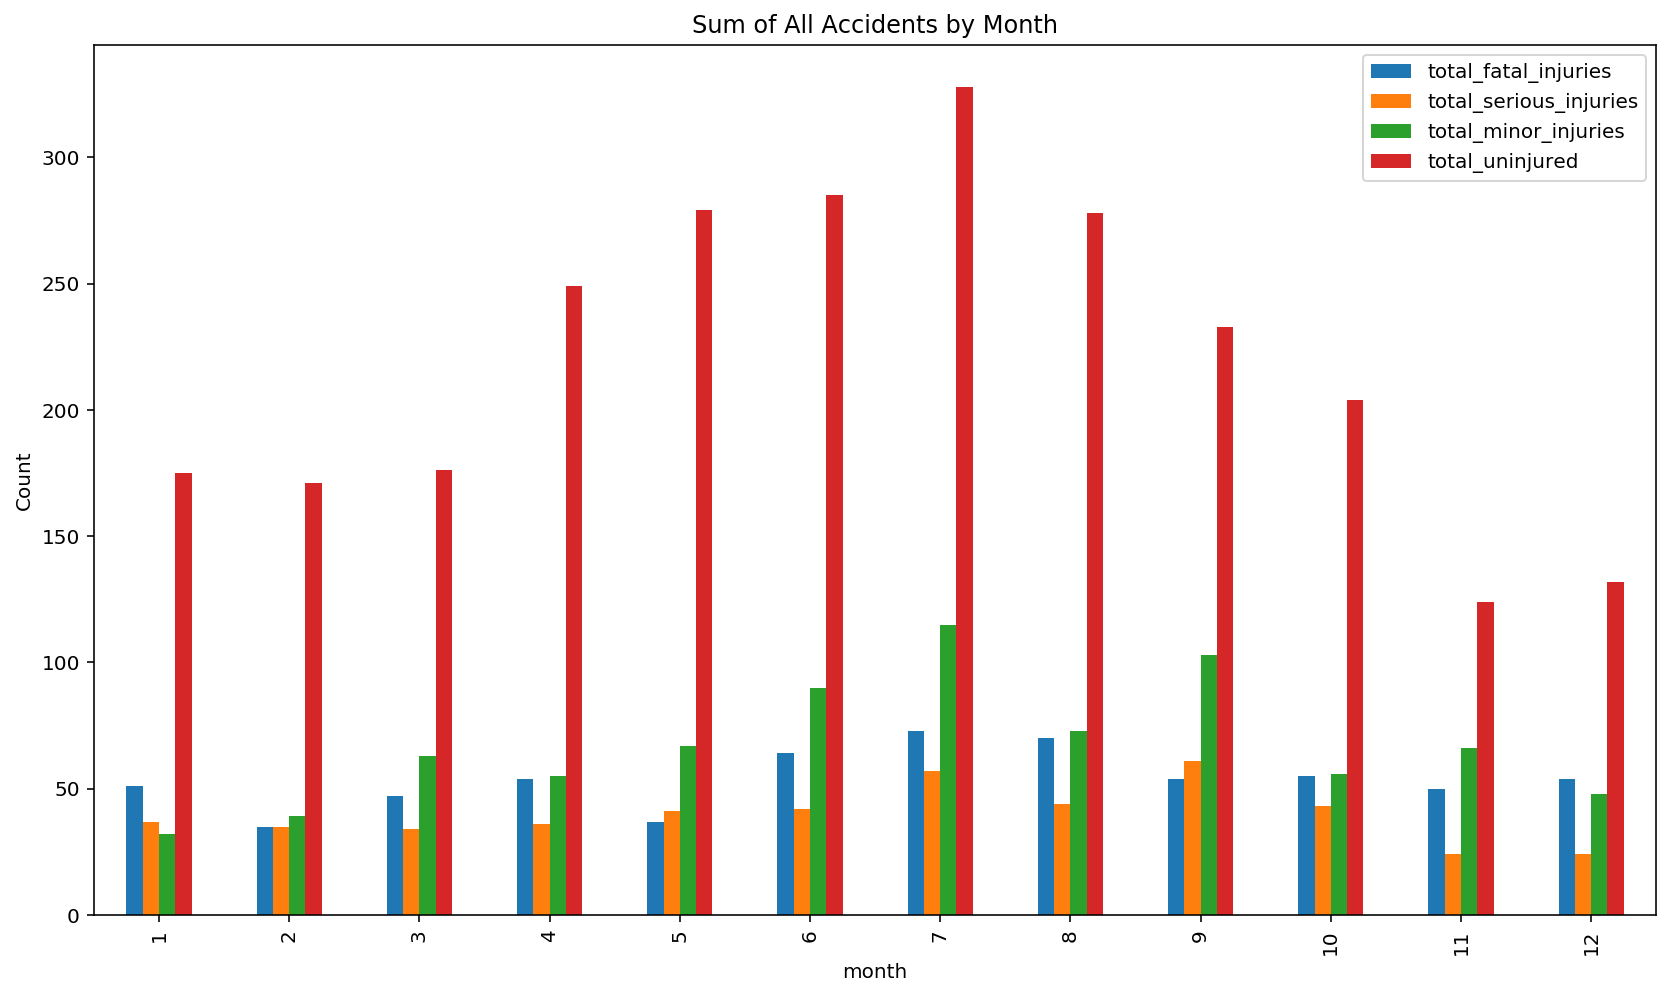

In [79]:
us_df.groupby(['month'])['total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured'].sum().plot(kind='bar', figsize = (14,8))
plt.ylabel('Count')
plt.title("Sum of All Accidents by Month");

I had wondered if I would see a spike in accidents of private pilots around March (thinking they've had the winter off and have come back a bit rusty) but all this shows is that during the seasons when you expect private pilots to be flying, they have increased rates of accidents, with no "Spring" spike.

##   

##  Looking at POB and if that makes a difference

In [80]:
pob=us_df[['people_on_board', 'total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured']]

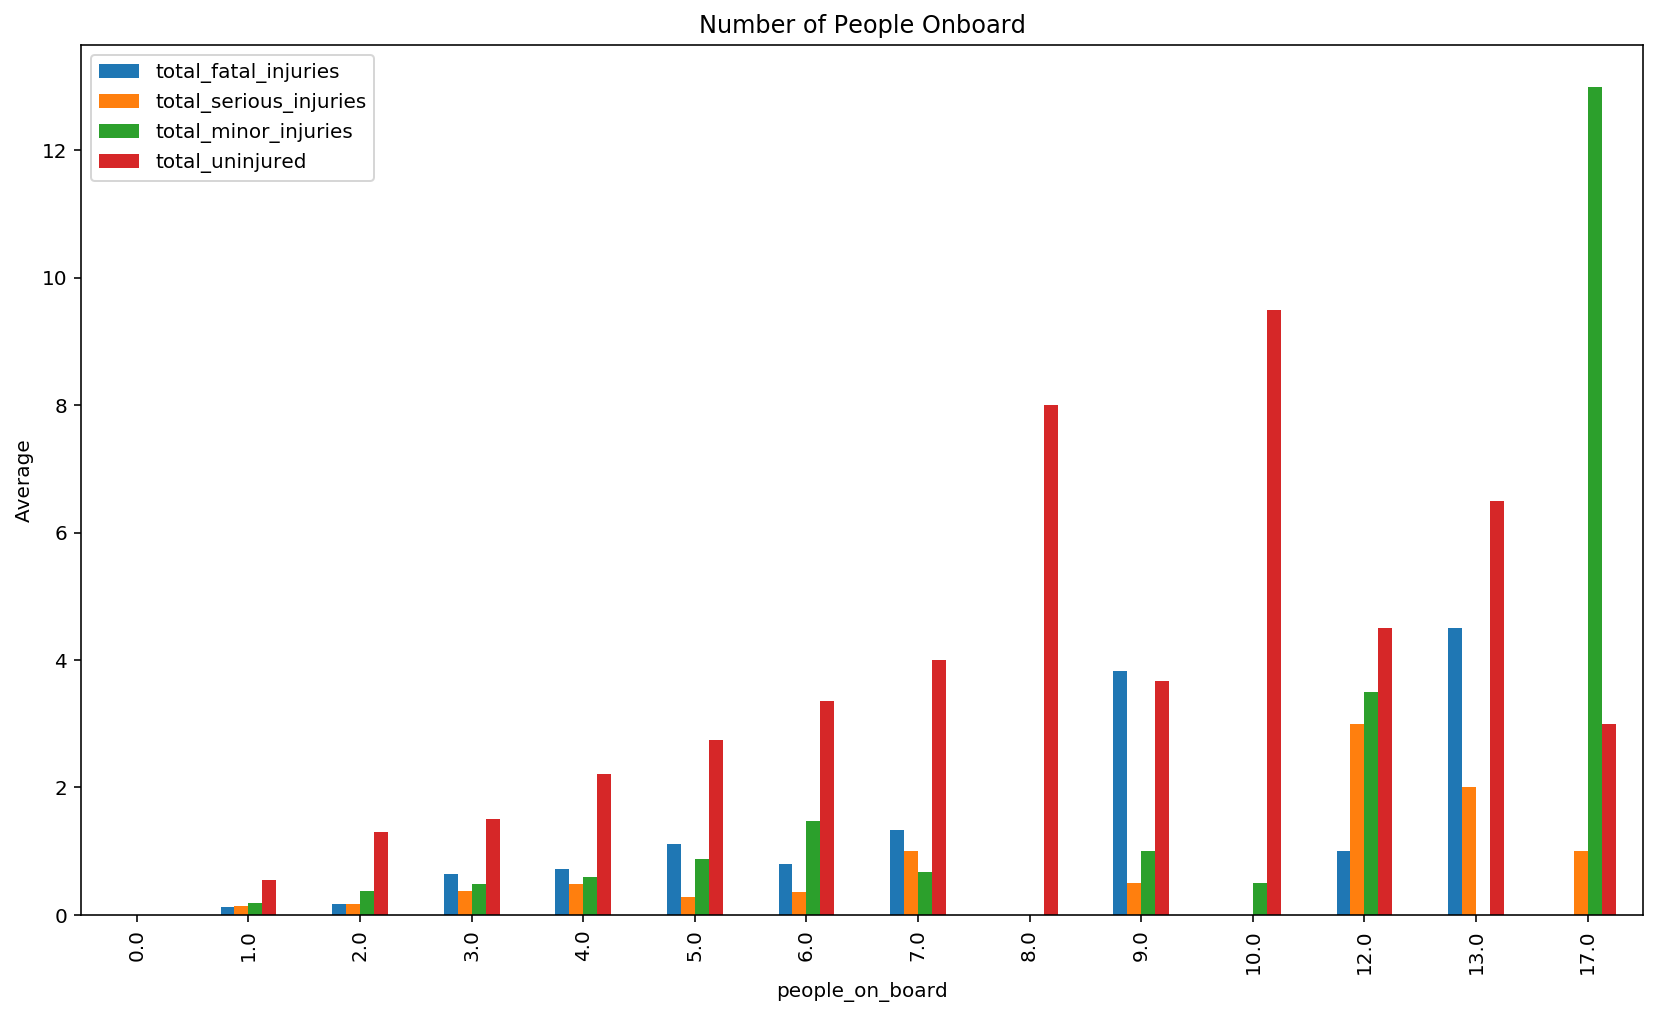

In [81]:
pob.groupby(['people_on_board'])[ 'total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured'].mean().plot(kind='bar', figsize = (14,8))
plt.ylabel('Average')
plt.title('Number of People Onboard');

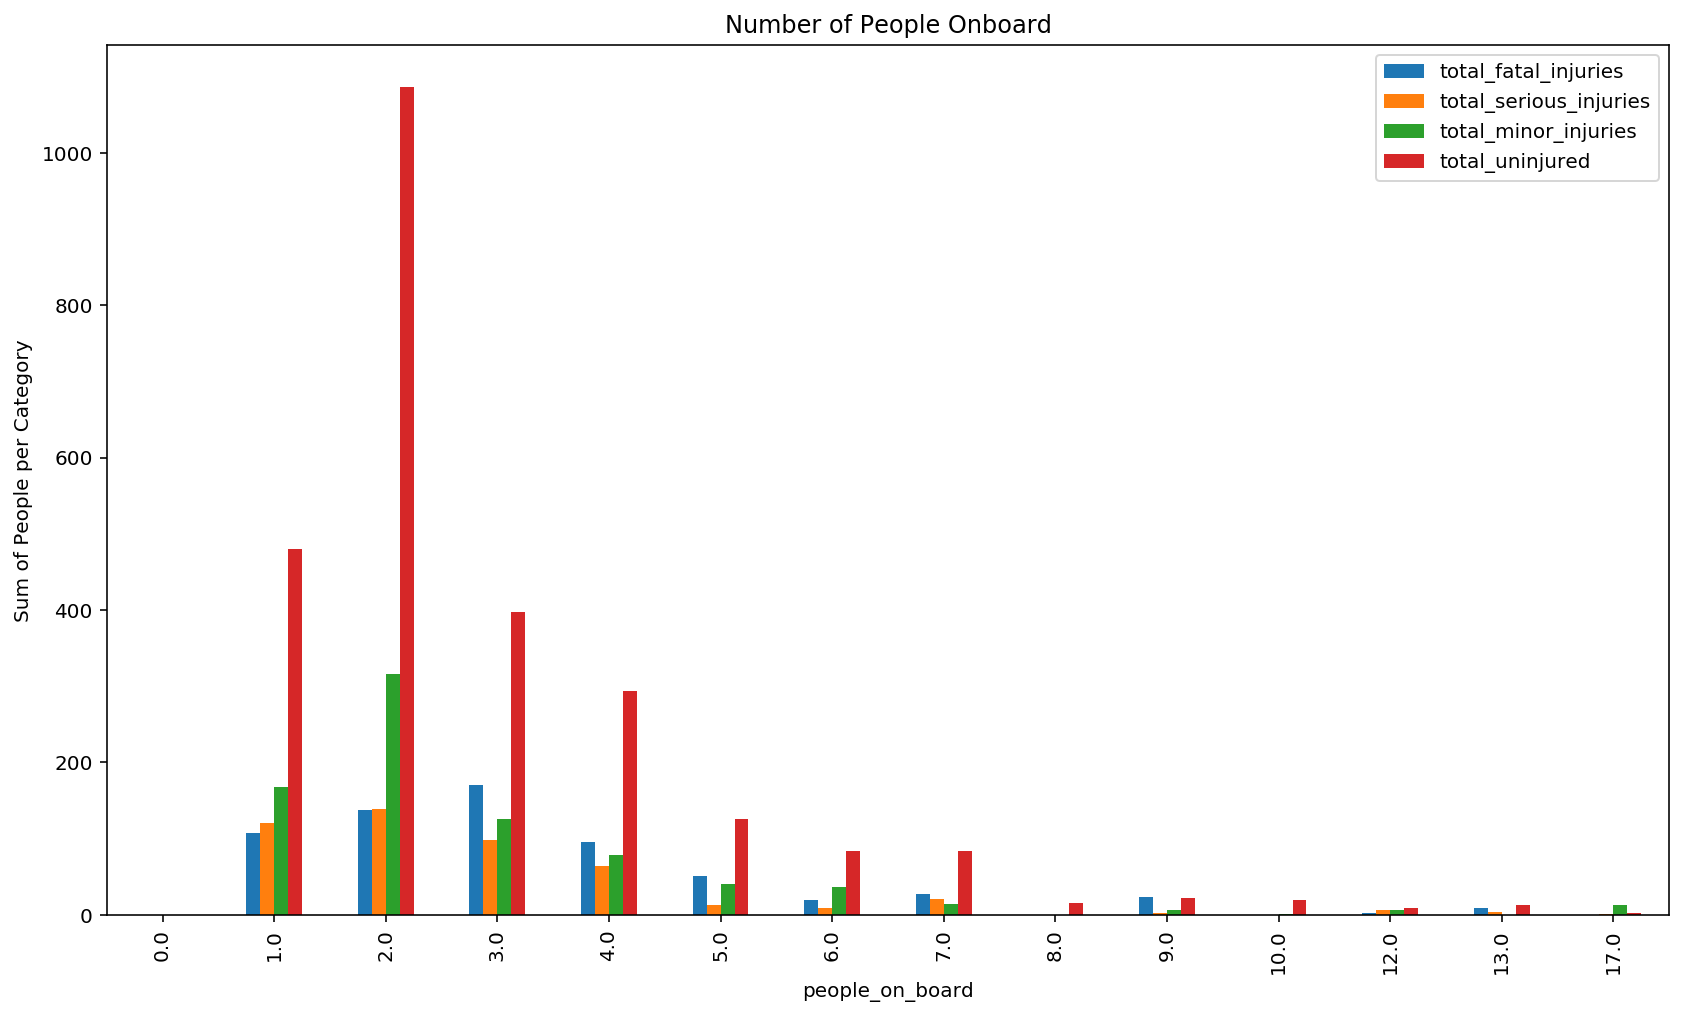

In [82]:
pob.groupby(['people_on_board'])[ 'total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured'].sum().plot(kind='bar', figsize = (14,8))
plt.ylabel('Sum of People per Category')
plt.title('Number of People Onboard');

I had wondered whether having more than just the pilot may have distracted them. 
It would appear that having someone sitting next to the pilot may cause influence non_fatal accidents.

## Looking at Makes of Helicopters

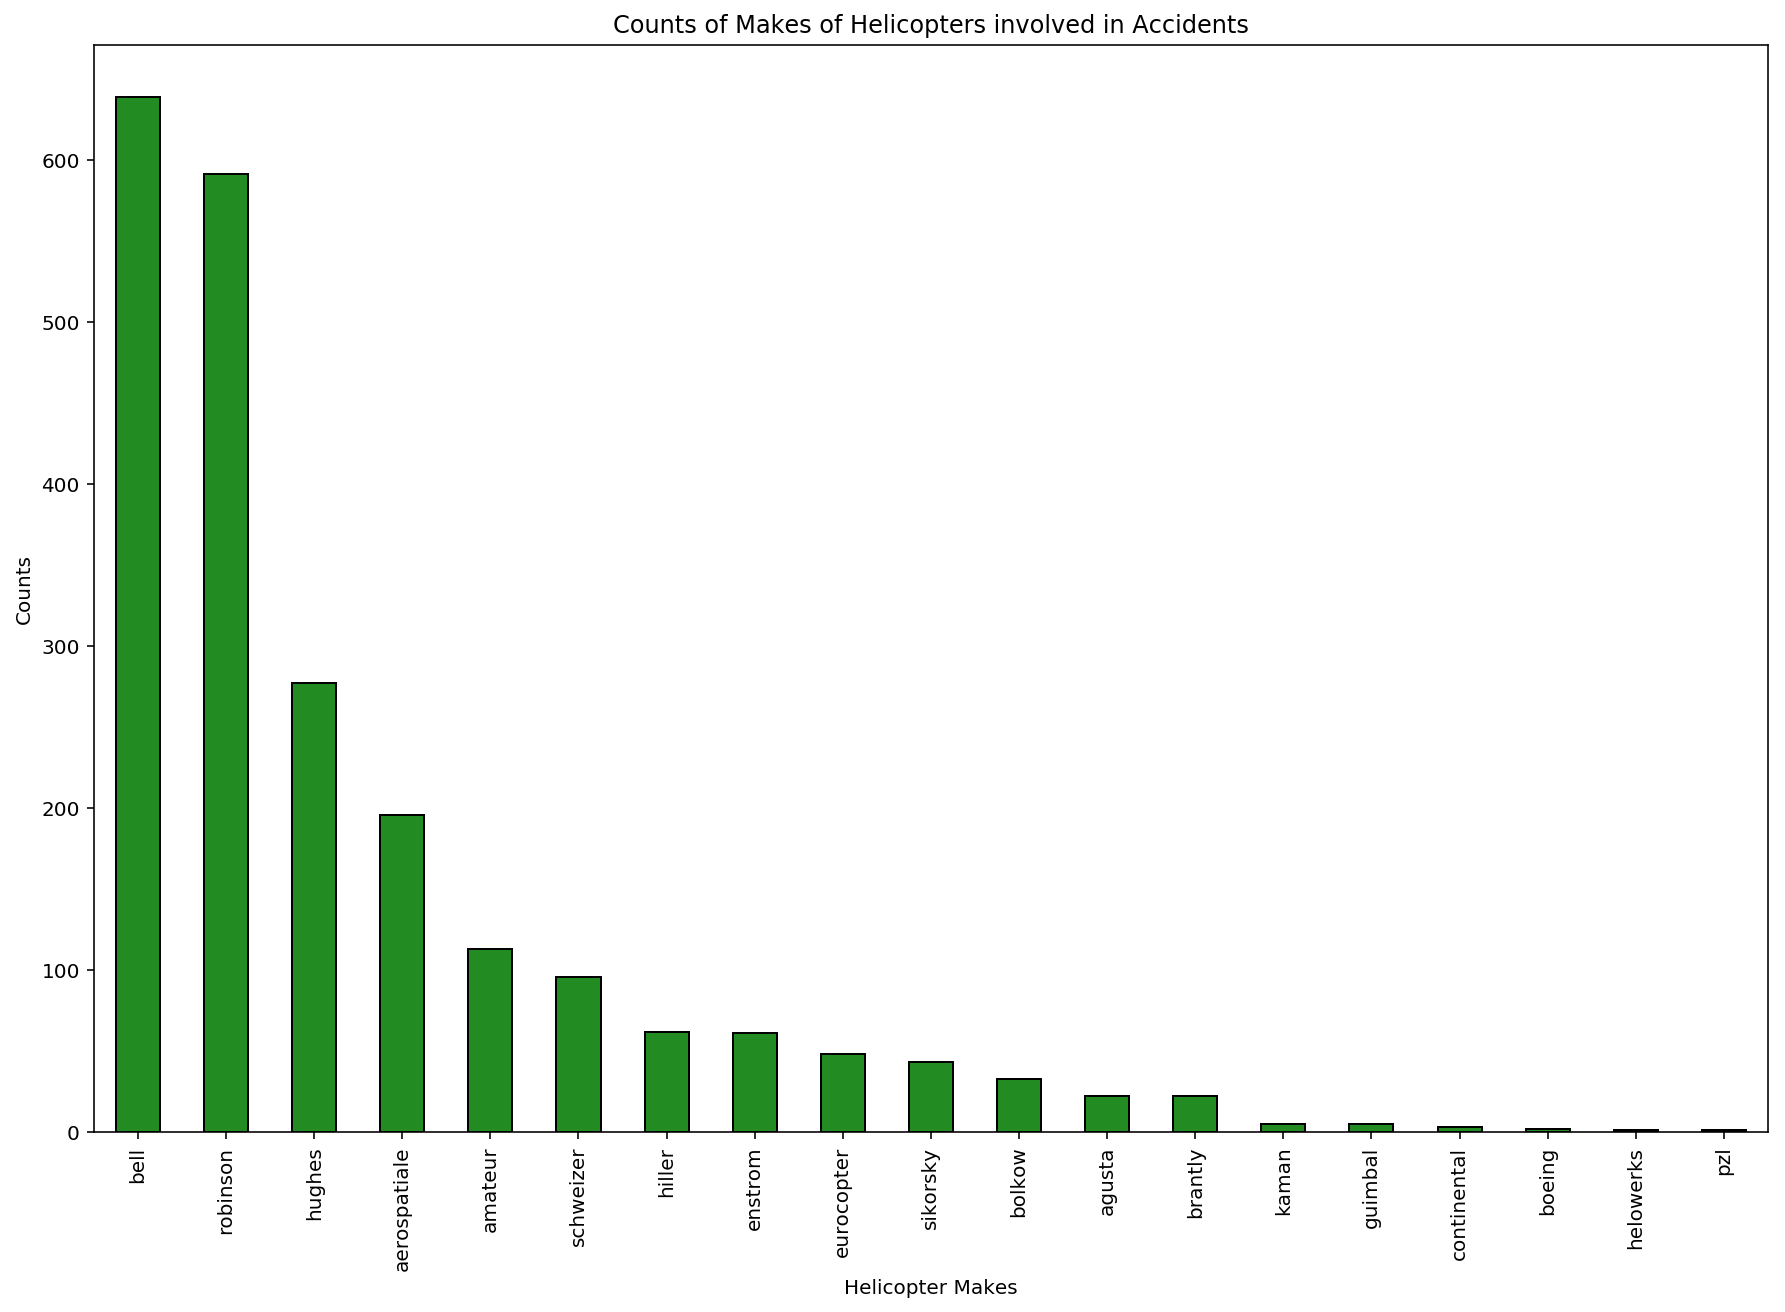

In [83]:
fig,ax=plt.subplots(figsize = [15,10])
ax = us_df.make.value_counts().plot(kind='bar', edgecolor='black', lw=1, color='forestgreen')
ax.set_ylabel('Counts')
ax.set_xlabel('Helicopter Makes')
_ = ax.set_title('Counts of Makes of Helicopters involved in Accidents')

Without knowing the number of flights (without accidents) it is difficult to say if this is relevant. Of private pilots
in the UK, common helicopter makes are Robinson, Bell and Eurocopter.

In [84]:
us_df.make.value_counts()

bell            639
robinson        591
hughes          277
aerospatiale    196
amateur         113
schweizer       96 
hiller          62 
enstrom         61 
eurocopter      48 
sikorsky        43 
bolkow          33 
agusta          22 
brantly         22 
kaman           5  
guimbal         5  
continental     3  
boeing          2  
helowerks       1  
pzl             1  
Name: make, dtype: int64

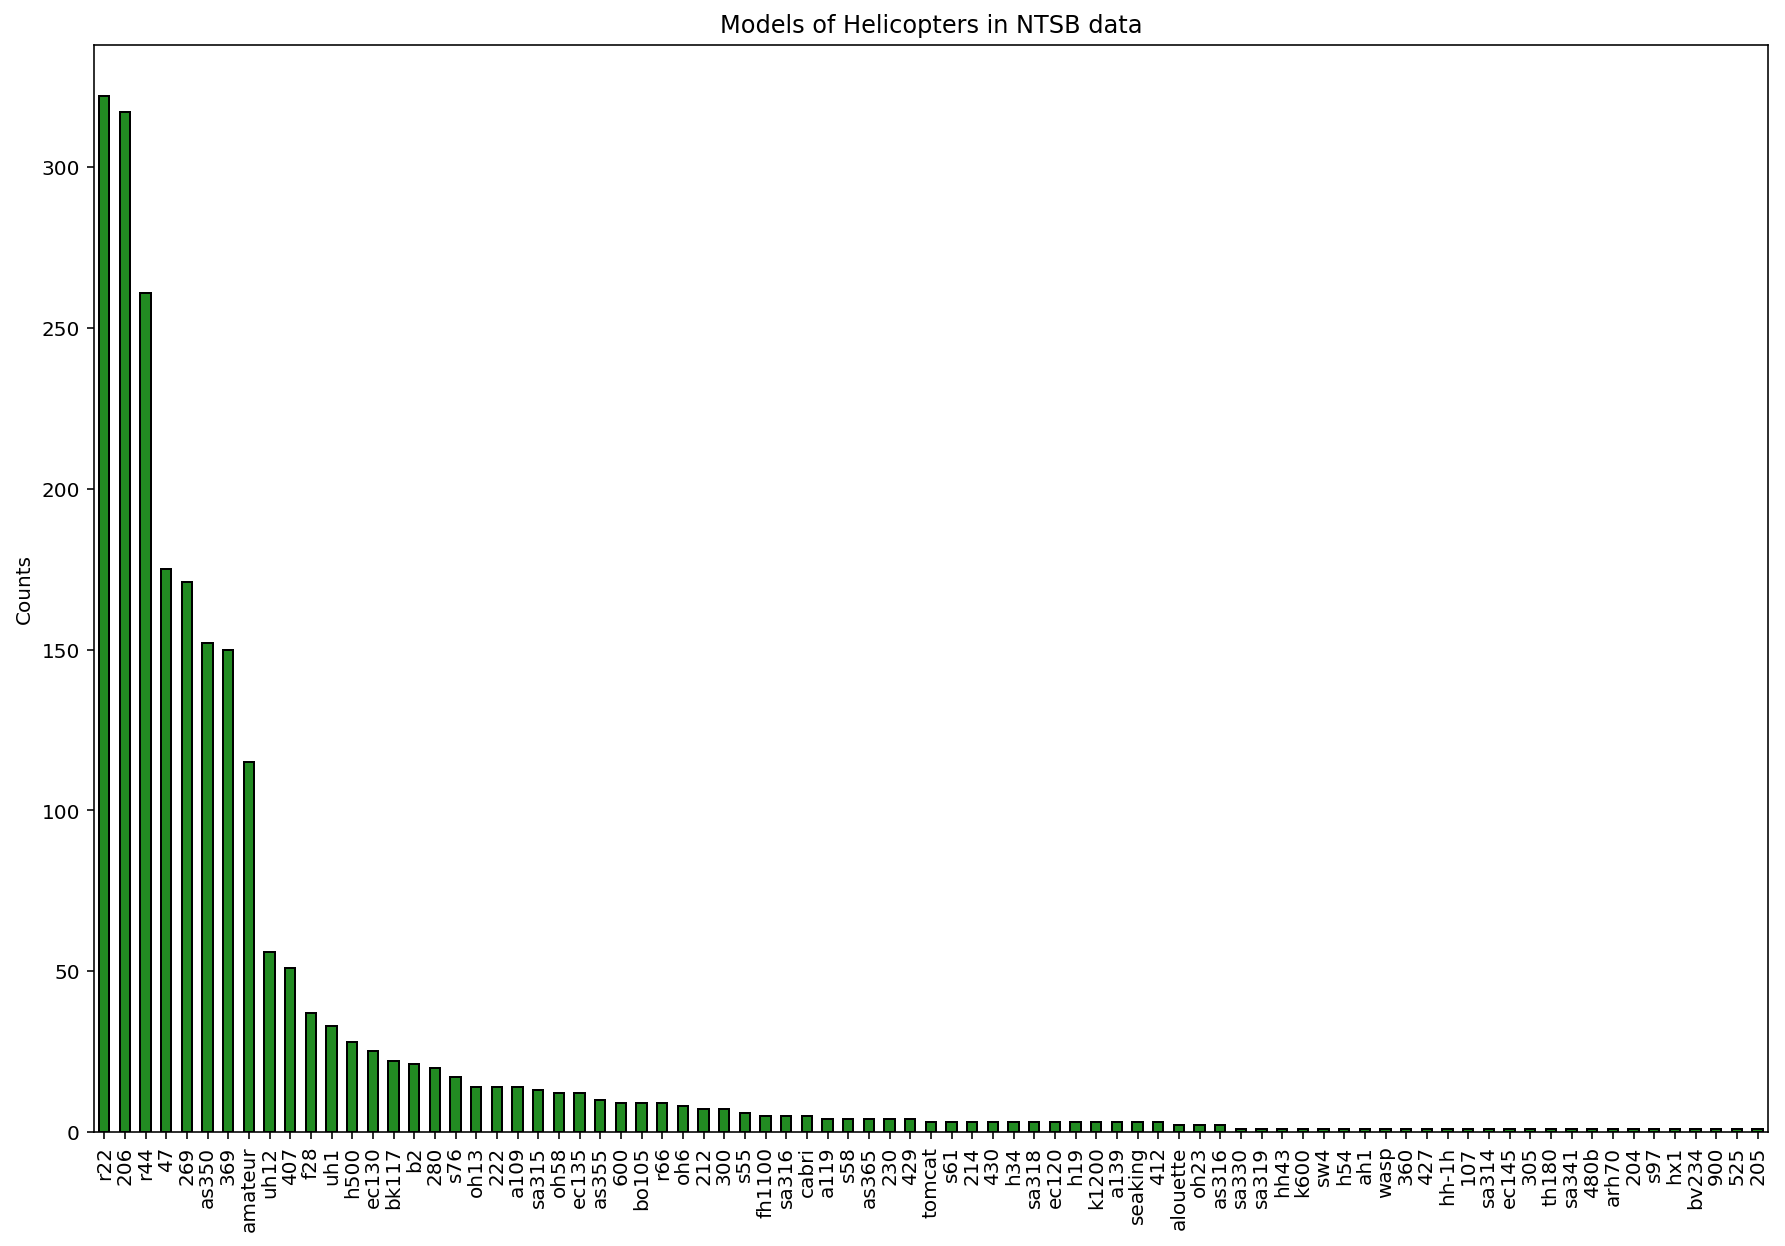

In [85]:
fig,ax = plt.subplots(figsize = [15,10])
ax = us_df.model.value_counts().plot(kind='bar', edgecolor='black', lw=1, color='forestgreen')
ax.set_ylabel('Counts')
_ = ax.set_title('Models of Helicopters in NTSB data')

In [86]:
make=us_df[['make', 'total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured']]

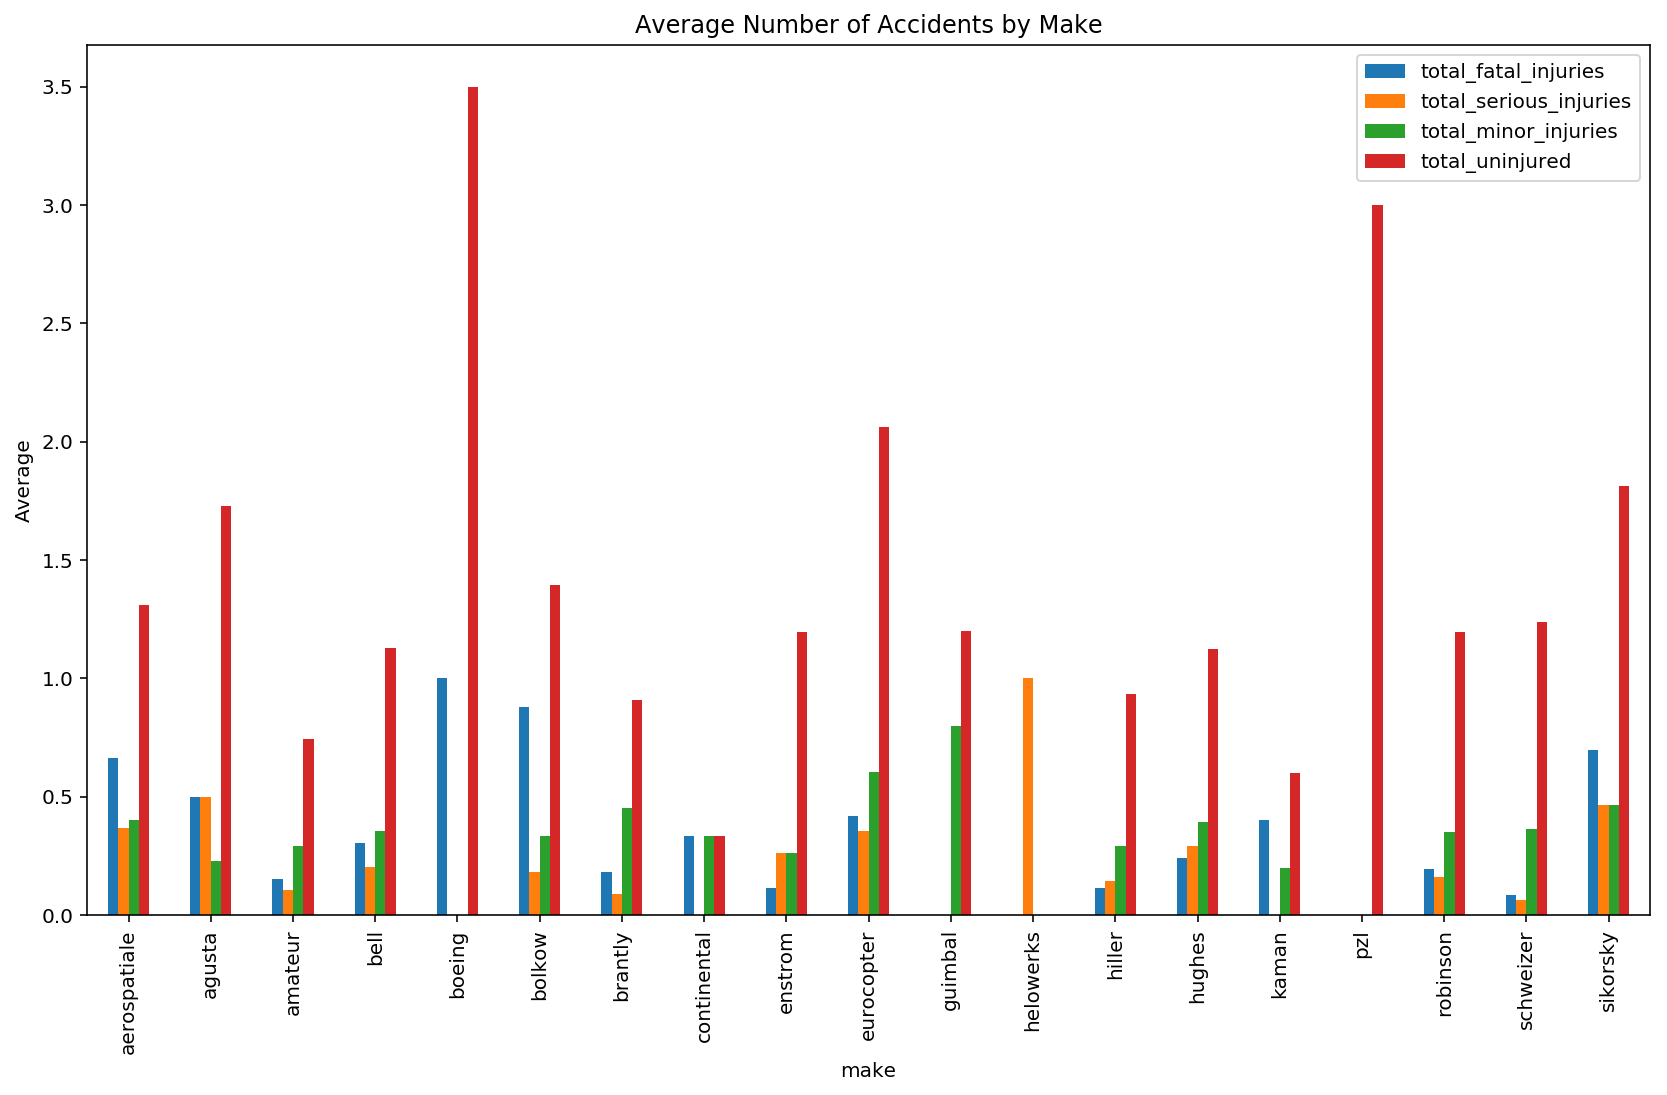

In [87]:
make.groupby(['make'])[ 'total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured'].mean().plot(kind='bar', figsize = (14,8))
plt.ylabel('Average')
plt.title('Average Number of Accidents by Make');

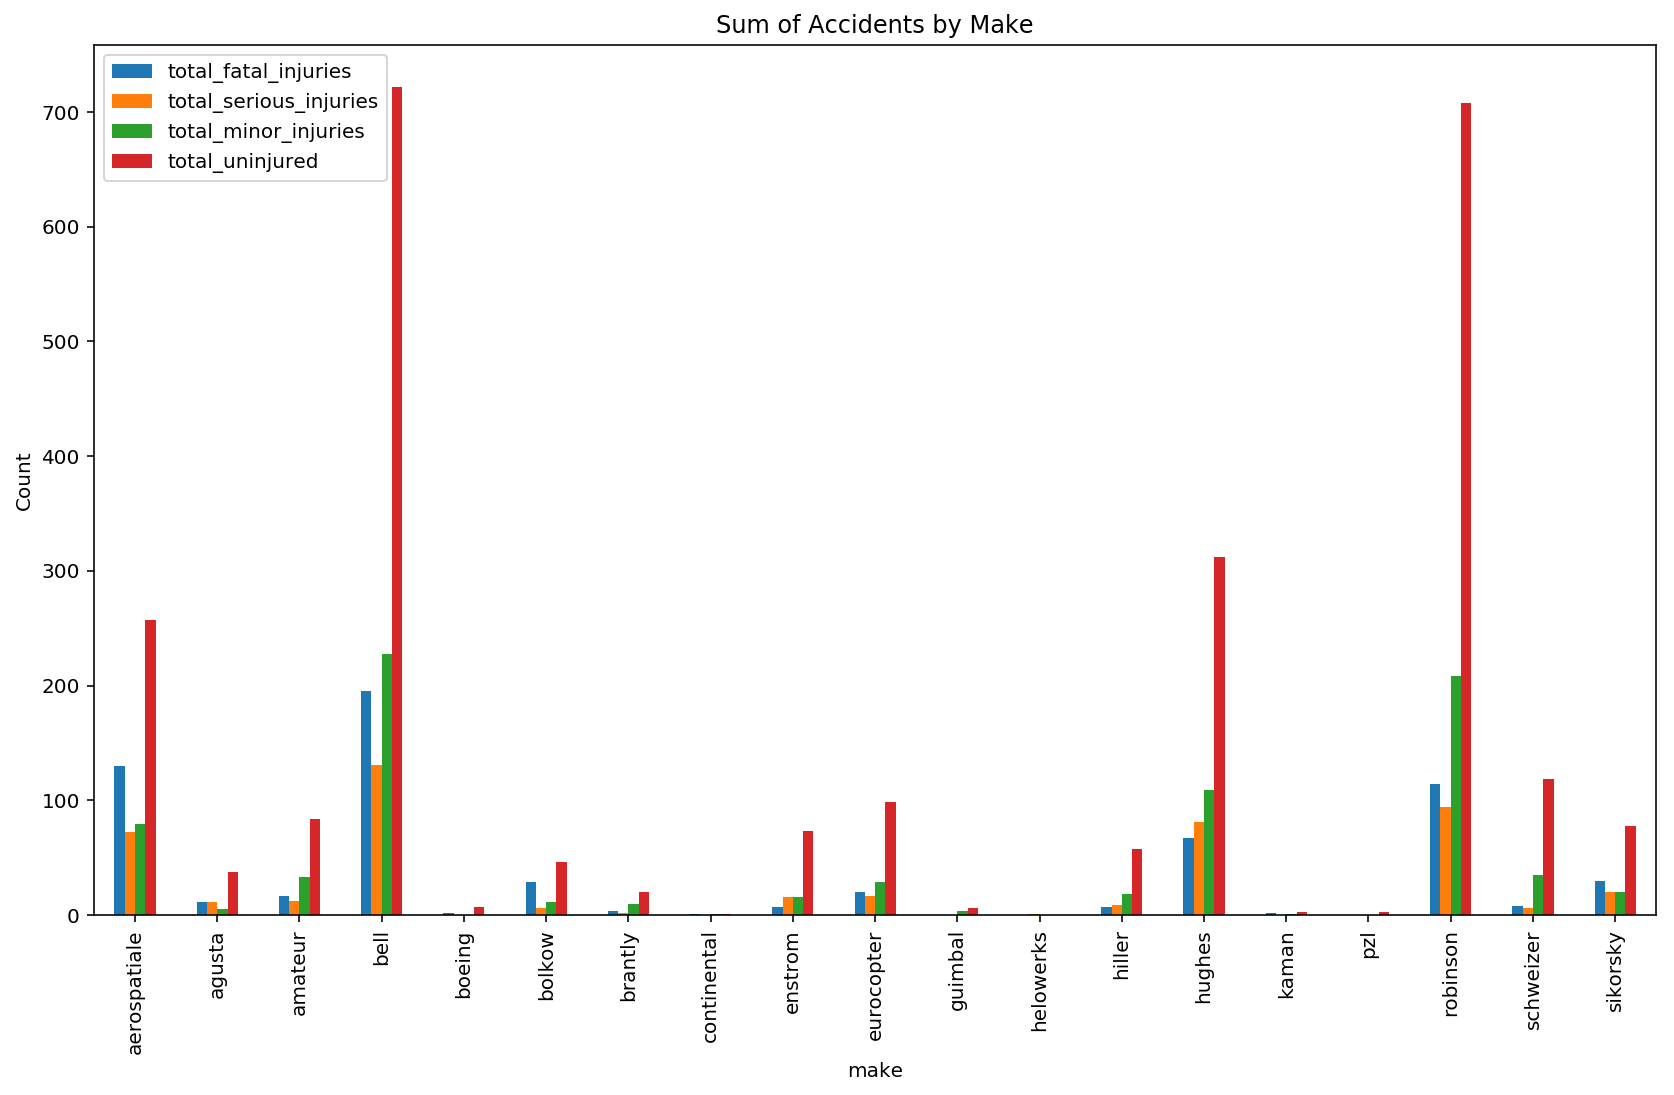

In [88]:
make.groupby(['make'])[ 'total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured'].sum().plot(kind='bar', figsize = (14,8))
plt.ylabel('Count')
plt.title('Sum of Accidents by Make');

It looks like aerospatiale, bolkow and sikorsky have the highest fatality rate compared to accidents.


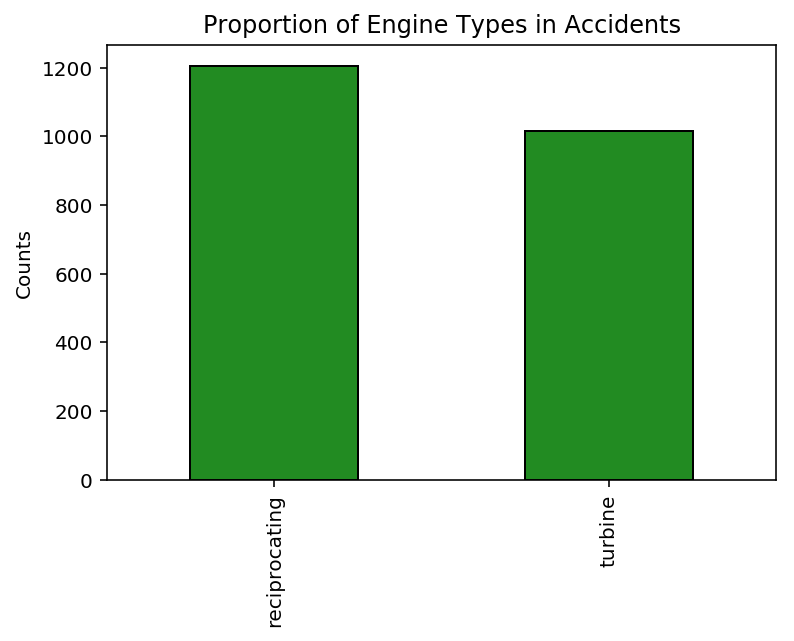

In [89]:
ax = us_df.engine_type1.value_counts().plot(kind='bar', edgecolor='black', lw=1, color='forestgreen')
ax.set_ylabel('Counts')
_ = ax.set_title('Proportion of Engine Types in Accidents')

In [90]:
make.groupby('make').total_fatal_injuries.agg(['count', 'mean', 'min', 'max']).sort_values('mean', ascending=False)

,count,mean,min,max
make,,,,
boeing,2,1.000000,0.0,2.0
bolkow,33,0.878788,0.0,4.0
sikorsky,43,0.697674,0.0,9.0
aerospatiale,196,0.663265,0.0,9.0
agusta,22,0.500000,0.0,3.0
eurocopter,48,0.416667,0.0,5.0
kaman,5,0.400000,0.0,1.0
continental,3,0.333333,0.0,1.0
bell,639,0.305164,0.0,7.0


In [91]:
make.groupby('make').total_fatal_injuries.agg(['count', 'mean', 'min', 'max']).sort_values('count', ascending=False)

,count,mean,min,max
make,,,,
bell,639,0.305164,0.0,7.0
robinson,591,0.192893,0.0,5.0
hughes,277,0.241877,0.0,4.0
aerospatiale,196,0.663265,0.0,9.0
amateur,113,0.150442,0.0,3.0
schweizer,96,0.083333,0.0,2.0
hiller,62,0.112903,0.0,3.0
enstrom,61,0.114754,0.0,2.0
eurocopter,48,0.416667,0.0,5.0


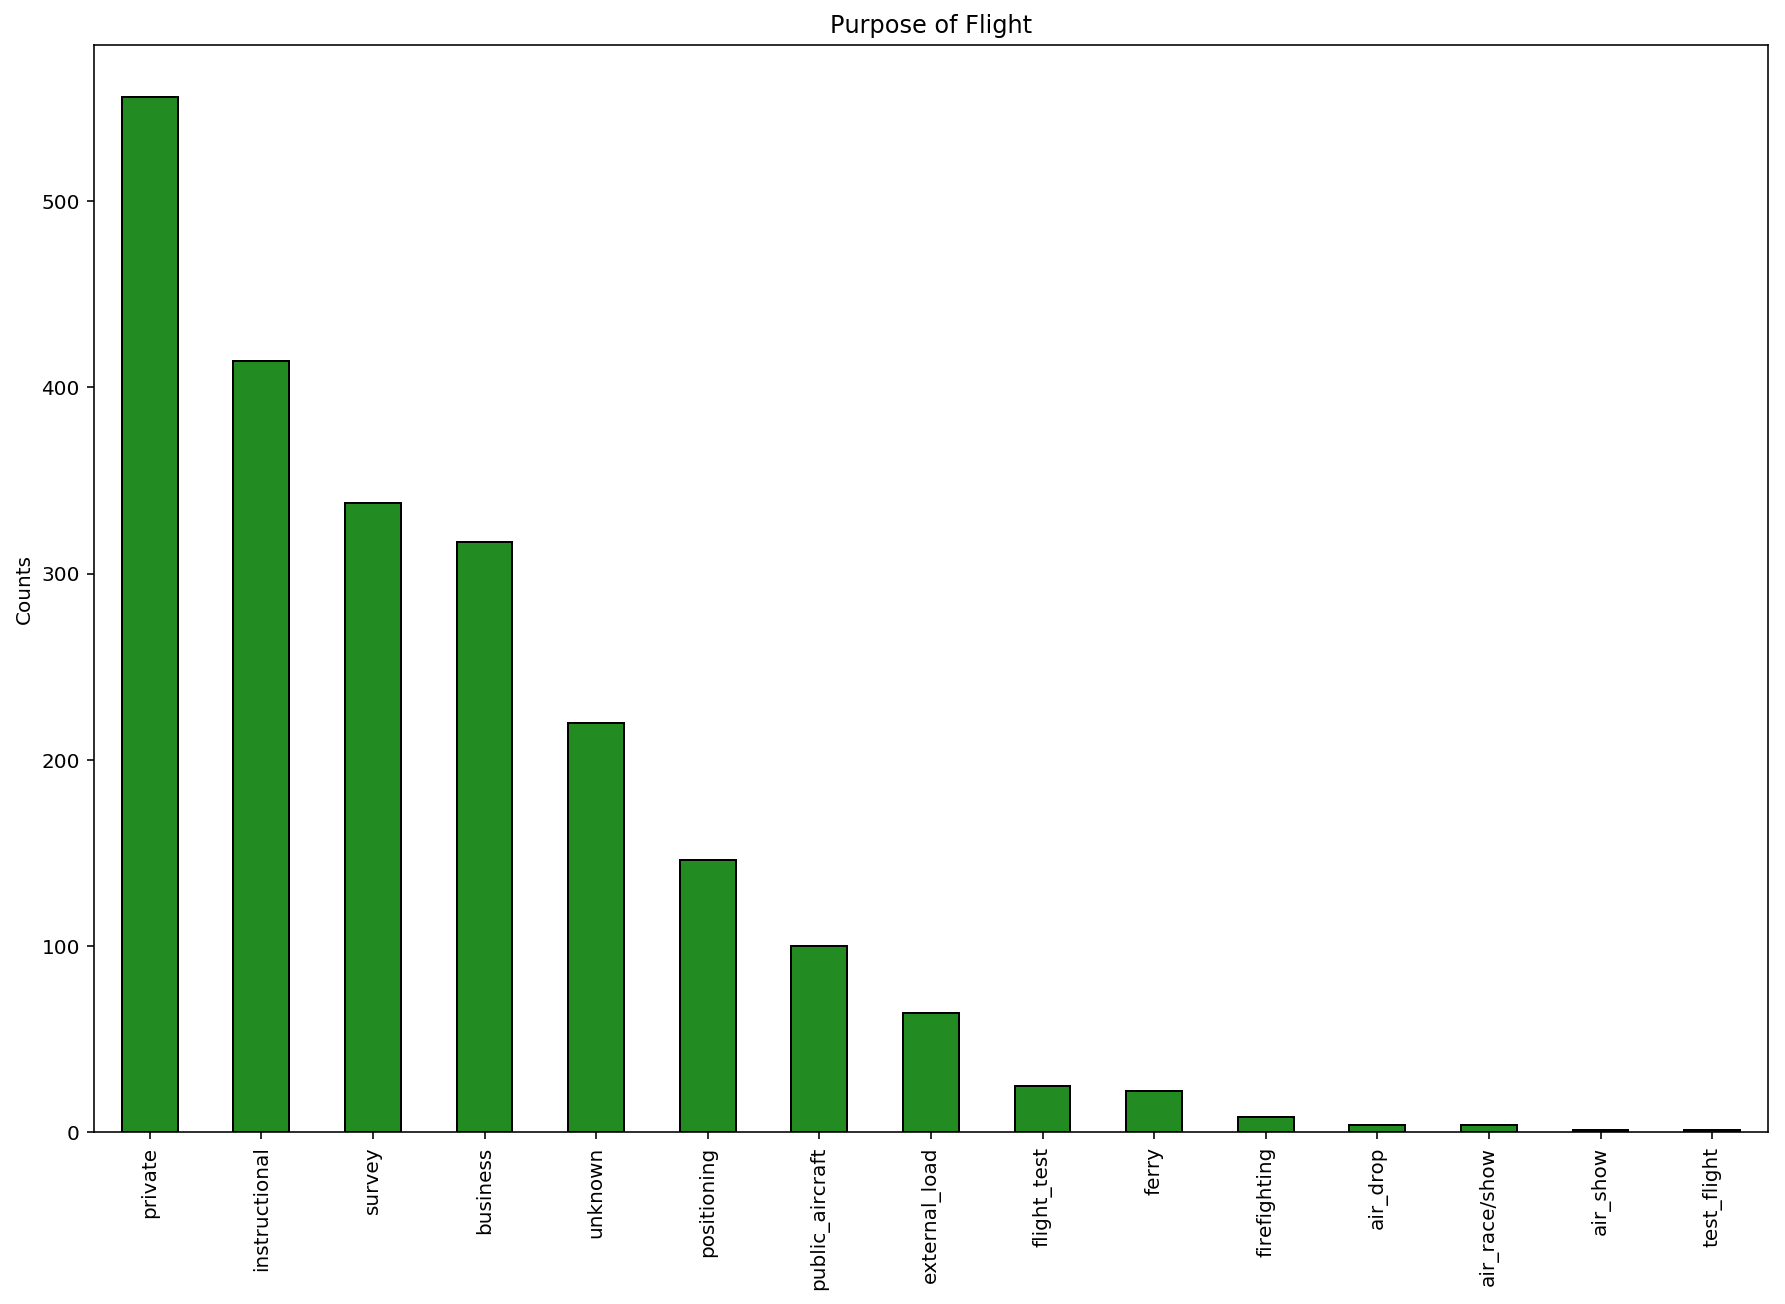

In [92]:
fig,ax= plt.subplots(figsize = [15,10])
ax = us_df.purpose_of_flight.value_counts().plot(kind='bar', edgecolor='black', lw=1, color='forestgreen')
ax.set_ylabel('Counts')
_ = ax.set_title('Purpose of Flight')

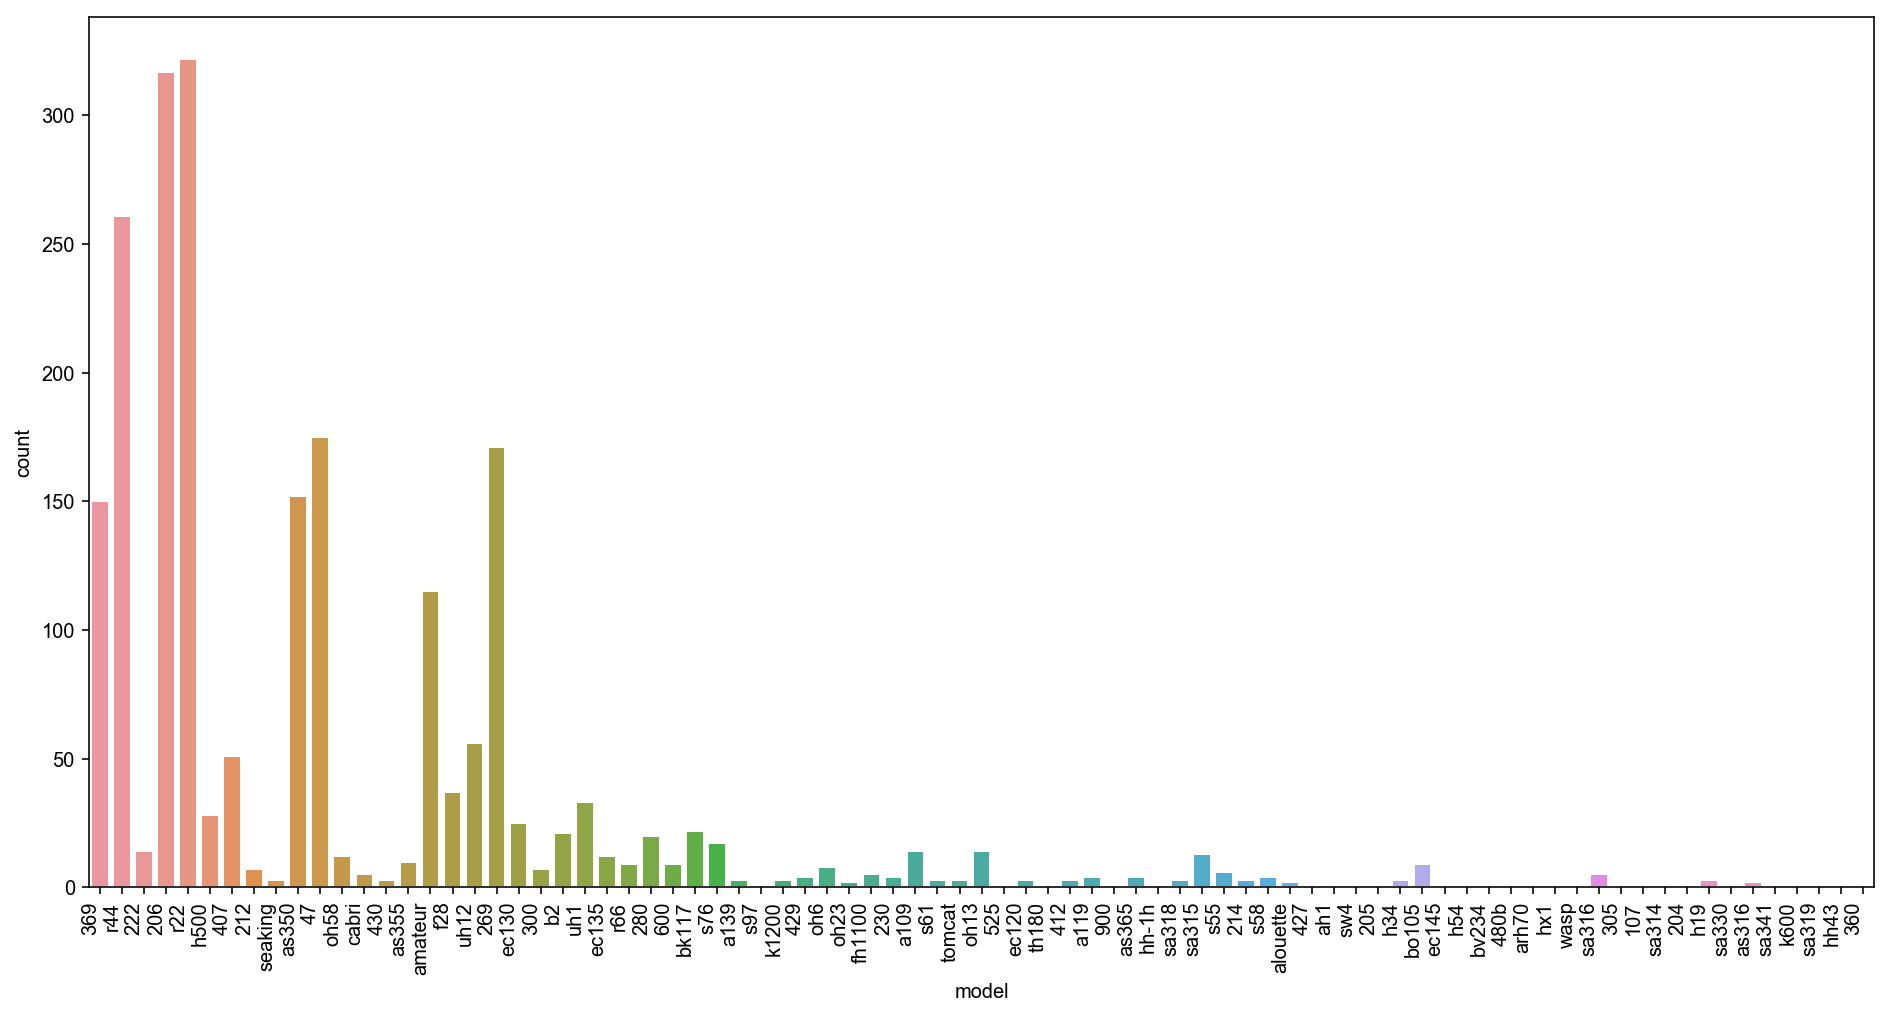

In [93]:
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
sns.set(style="darkgrid")
ax = sns.countplot(x="model", data=us_df)
plt.xticks(rotation = 90,ha = 'right');

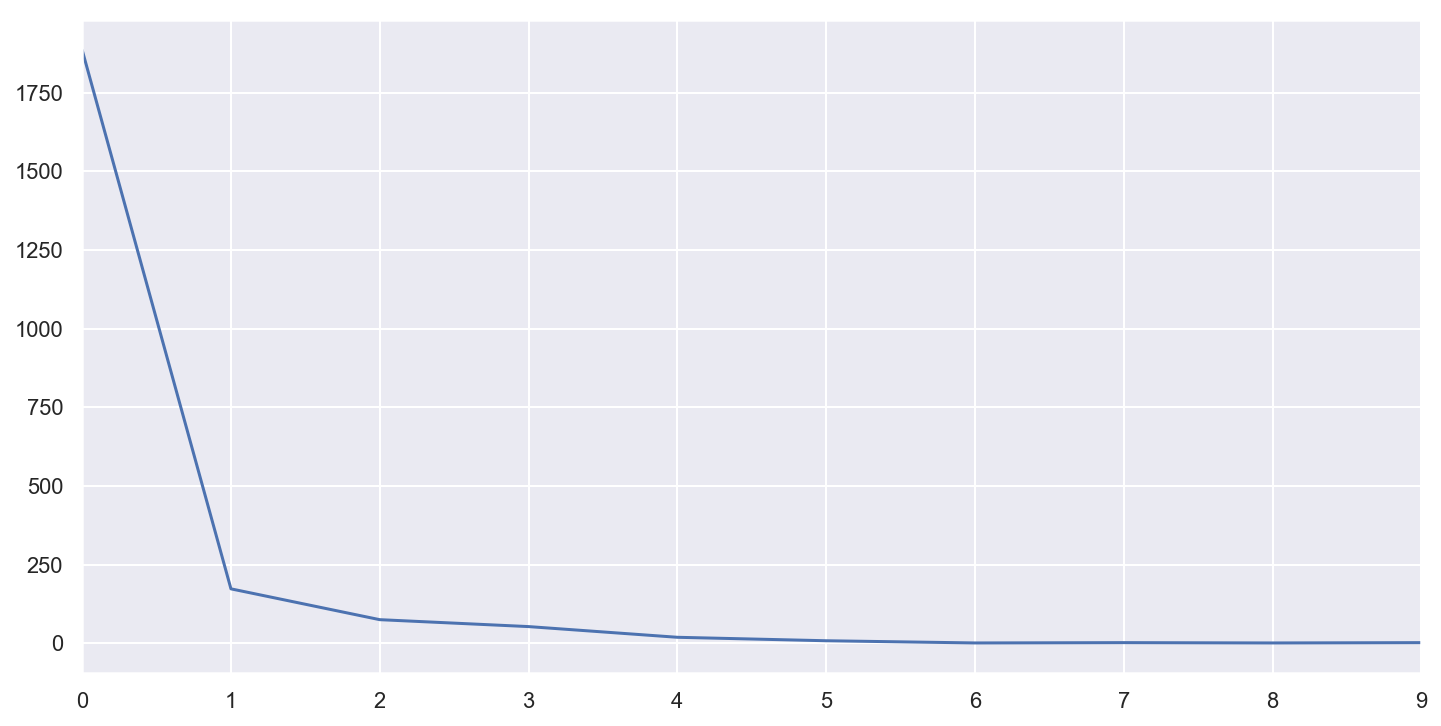

In [94]:
us_df.total_fatal_injuries.value_counts().sort_index().plot(figsize = (12,6));

Fatalities usually occur in smaller numbers

In [95]:
us_df.columns

Index(['make', 'model', 'engine_type1', 'amateur_built', 'event_date',
       'location', 'country', 'injury_severity', 'purpose_of_flight',
       'weather_condition', 'broad_phase_of_flight', 'total_fatal_injuries',
       'total_serious_injuries', 'total_minor_injuries', 'total_uninjured',
       'people_on_board', 'phase_of_flight', 'latitude', 'longitude',
       'aircraft_damage', 'investigation_type', 'day_of_week', 'month',
       'no_of_engines1', 'pilot_type', 'fatalities'],
      dtype='object')

In [96]:
us_df['proportion_survival']=((us_df.total_serious_injuries)+(us_df.total_minor_injuries) + (us_df.total_uninjured))/(us_df.people_on_board)



/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [97]:
sum(us_df.total_serious_injuries)

478.0

In [98]:
sum(us_df.total_minor_injuries)

807.0

In [99]:
sum(us_df.total_uninjured)

2634.0

In [100]:
sum(us_df.people_on_board)

4563.0

## Looking at spread of the fatalities over time

In [101]:
us_df['date'] = pd.to_datetime(us_df.event_date)
us_df.set_index('date', inplace=True, drop = True)
us_df.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,make,model,engine_type1,amateur_built,event_date,location,country,injury_severity,purpose_of_flight,weather_condition,broad_phase_of_flight,total_fatal_injuries,total_serious_injuries,total_minor_injuries,total_uninjured,people_on_board,phase_of_flight,latitude,longitude,aircraft_damage,investigation_type,day_of_week,month,no_of_engines1,pilot_type,fatalities,proportion_survival
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-04-16,hughes,369,turbine,no,2019-04-16,"hauula,_hi",united_states,Non-Fatal,business,vmc,cruise,0.0,0.0,0.0,4.0,4.0,unknown,21.588333,-157.911944,substantial,accident,Tuesday,4,1,professional,non_fatal,1.00
2019-04-04,robinson,r44,reciprocating,no,2019-04-04,"tampa,_fl",united_states,Fatal(1),private,vmc,cruise,1.0,1.0,0.0,2.0,4.0,unknown,27.943333,-82.401944,substantial,accident,Thursday,4,1,private,fatal,0.75
2019-04-02,robinson,r44,reciprocating,no,2019-04-02,"taunton,_ma",united_states,Non-Fatal,instructional,vmc,maneuvering,0.0,0.0,0.0,2.0,2.0,unknown,41.874445,-71.016389,substantial,accident,Tuesday,4,1,instructional,non_fatal,1.00
2019-03-30,bell,222,turbine,no,2019-03-30,"montgomery,_ny",united_states,Non-Fatal,private,vmc,takeoff,0.0,0.0,1.0,5.0,6.0,unknown,41.539444,-74.306944,substantial,accident,Saturday,3,2,private,non_fatal,1.00
2019-03-29,bell,206,turbine,no,2019-03-29,"valley_center,_ca",united_states,Non-Fatal,survey,unknown,unknown,0.0,0.0,1.0,0.0,1.0,unknown,33.218370,-117.034197,substantial,accident,Friday,3,1,professional,non_fatal,1.00


In [102]:
data=us_df.drop(['injury_severity', 'total_fatal_injuries', 'total_serious_injuries', 'total_uninjured', 'total_minor_injuries','country','location', 'investigation_type', 'month'], axis = 1)

In [103]:
data.head()

,make,model,engine_type1,amateur_built,event_date,purpose_of_flight,weather_condition,broad_phase_of_flight,people_on_board,phase_of_flight,latitude,longitude,aircraft_damage,day_of_week,no_of_engines1,pilot_type,fatalities,proportion_survival
date,,,,,,,,,,,,,,,,,,
2019-04-16,hughes,369,turbine,no,2019-04-16,business,vmc,cruise,4.0,unknown,21.588333,-157.911944,substantial,Tuesday,1,professional,non_fatal,1.00
2019-04-04,robinson,r44,reciprocating,no,2019-04-04,private,vmc,cruise,4.0,unknown,27.943333,-82.401944,substantial,Thursday,1,private,fatal,0.75
2019-04-02,robinson,r44,reciprocating,no,2019-04-02,instructional,vmc,maneuvering,2.0,unknown,41.874445,-71.016389,substantial,Tuesday,1,instructional,non_fatal,1.00
2019-03-30,bell,222,turbine,no,2019-03-30,private,vmc,takeoff,6.0,unknown,41.539444,-74.306944,substantial,Saturday,2,private,non_fatal,1.00
2019-03-29,bell,206,turbine,no,2019-03-29,survey,unknown,unknown,1.0,unknown,33.218370,-117.034197,substantial,Friday,1,professional,non_fatal,1.00


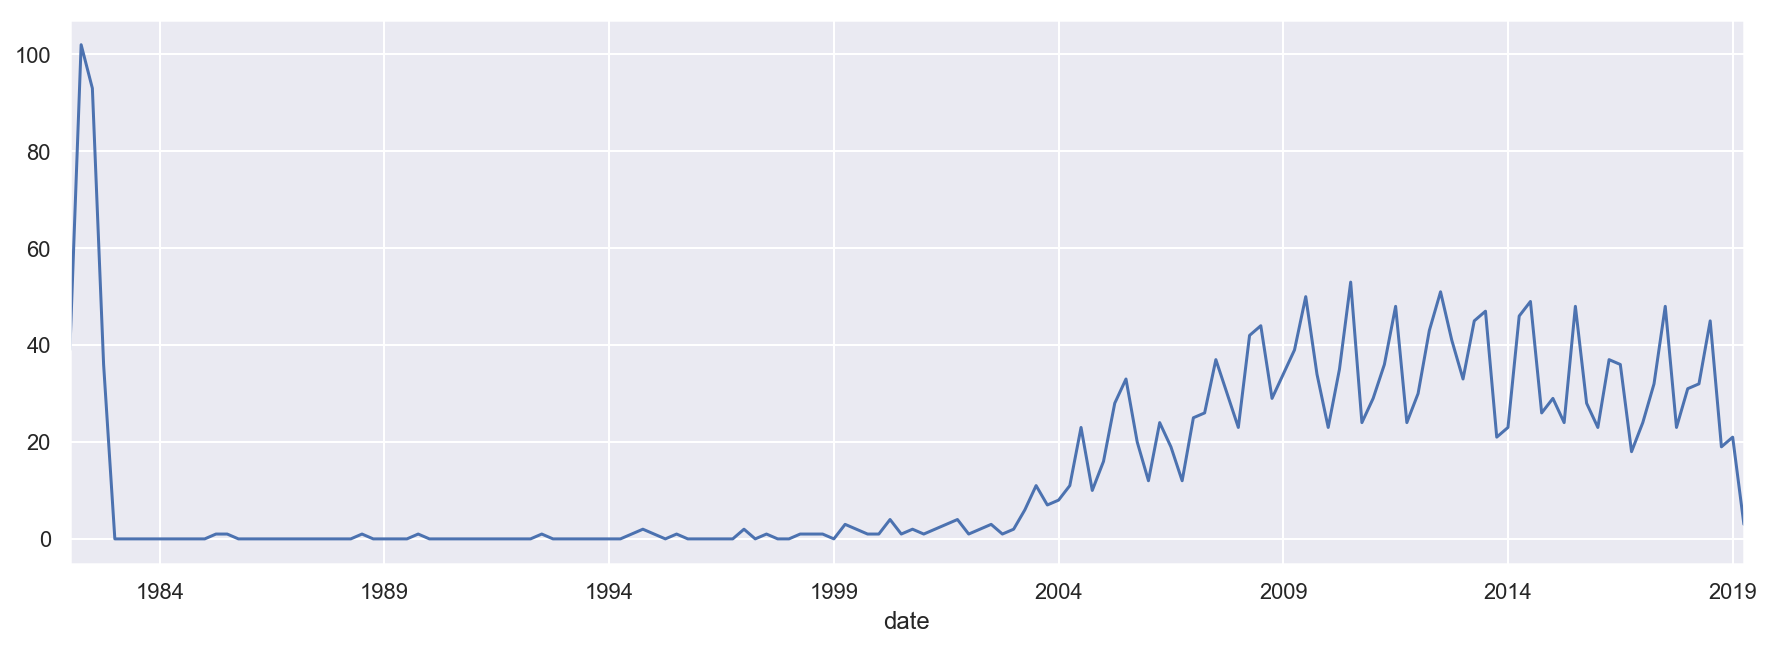

In [104]:
us_df.resample('Q')['make'].count().plot(figsize = [15,5]);

The first spreadsheet of aviation accidents/incidents on the NTSB website is 1998.
The graph above, it appears that while data was being reported from 1998, there may not have been thorough processes/reporting protocols in place resulting in adhoc reporting until 2003.
For that reason, I plan to look at data from 2003 onwards.

In [105]:
# making columns from data index (in case I need them)
data['year']= us_df.index.year
data['month']= us_df.index.month
data['day']= us_df.index.day

In [106]:
mask_2003 = data['year'] >2002
usdf2003= data[mask_2003]

In [107]:
usdf2003['date'] = pd.to_datetime(usdf2003.event_date).dt.to_period('M')
usdf2003.set_index('date', inplace=True, drop = True)
usdf2003.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,make,model,engine_type1,amateur_built,event_date,purpose_of_flight,weather_condition,broad_phase_of_flight,people_on_board,phase_of_flight,latitude,longitude,aircraft_damage,day_of_week,no_of_engines1,pilot_type,fatalities,proportion_survival,year,month,day
date,,,,,,,,,,,,,,,,,,,,,
2019-04,hughes,369,turbine,no,2019-04-16,business,vmc,cruise,4.0,unknown,21.588333,-157.911944,substantial,Tuesday,1,professional,non_fatal,1.00,2019,4,16
2019-04,robinson,r44,reciprocating,no,2019-04-04,private,vmc,cruise,4.0,unknown,27.943333,-82.401944,substantial,Thursday,1,private,fatal,0.75,2019,4,4
2019-04,robinson,r44,reciprocating,no,2019-04-02,instructional,vmc,maneuvering,2.0,unknown,41.874445,-71.016389,substantial,Tuesday,1,instructional,non_fatal,1.00,2019,4,2
2019-03,bell,222,turbine,no,2019-03-30,private,vmc,takeoff,6.0,unknown,41.539444,-74.306944,substantial,Saturday,2,private,non_fatal,1.00,2019,3,30
2019-03,bell,206,turbine,no,2019-03-29,survey,unknown,unknown,1.0,unknown,33.218370,-117.034197,substantial,Friday,1,professional,non_fatal,1.00,2019,3,29


##  Looking to see where the unknown values are

In [108]:
usdf2003.columns

Index(['make', 'model', 'engine_type1', 'amateur_built', 'event_date',
       'purpose_of_flight', 'weather_condition', 'broad_phase_of_flight',
       'people_on_board', 'phase_of_flight', 'latitude', 'longitude',
       'aircraft_damage', 'day_of_week', 'no_of_engines1', 'pilot_type',
       'fatalities', 'proportion_survival', 'year', 'month', 'day'],
      dtype='object')

make=0, model = 0, engine_type1 = 0, event_date = 0, amateur_built = 0, injury_severity = 0, 
total_fatal_injuries = 0, total_serious_injuries = 0, total_minor_injuries = 0, total_uninjured = 0, 
people_on_board = 0, day_of_week = 0, month = 0, no_of_engines1 = 0, fatalities = 0, proportion = 0,
weather_condition = 22, broad_phase_of_flight = 289, aircraft_damage = 15, pilot_type = 220

##  

Dropping phase of flight as it does not add value, and I have broad phase of flight.  
Dropping purpose of flight as information from this column has been used to generate the pilot type column where there is an assumption that all accidents that are not private, instructional or unknown are professional pilots 
who fly for a career therefore are trained to a higher level,and they also have more experience.
Dropping year, month, day as these are duplicates of event_date.

In [109]:
usdf_2003=usdf2003.drop(['phase_of_flight','purpose_of_flight', 'year', 'month', 'day'], axis = 1)


In [110]:
usdf_2003.columns

Index(['make', 'model', 'engine_type1', 'amateur_built', 'event_date',
       'weather_condition', 'broad_phase_of_flight', 'people_on_board',
       'latitude', 'longitude', 'aircraft_damage', 'day_of_week',
       'no_of_engines1', 'pilot_type', 'fatalities', 'proportion_survival'],
      dtype='object')

In [111]:
usdf_2003.proportion_survival.value_counts()

1.000000    1630
0.000000    189 
0.500000    27  
0.333333    13  
0.666667    13  
0.750000    12  
0.833333    2   
0.166667    2   
0.200000    2   
0.250000    2   
0.400000    2   
0.800000    2   
0.600000    2   
0.111111    1   
0.307692    1   
0.428571    1   
0.571429    1   
Name: proportion_survival, dtype: int64

In [112]:
usdf_2003.model.value_counts()

r22         297
206         270
r44         261
269         144
as350       141
369         128
47          118
amateur     101
407         51 
uh12        38 
uh1         30 
f28         29 
ec130       25 
h500        23 
b2          18 
bk117       18 
s76         14 
280         14 
oh13        13 
ec135       12 
oh58        12 
a109        11 
r66         9  
600         9  
222         8  
oh6         8  
300         7  
as355       6  
212         5  
cabri       5  
           ..  
a119        3  
s61         3  
k1200       3  
seaking     3  
ec120       3  
a139        3  
alouette    2  
230         2  
tomcat      2  
412         2  
oh23        2  
h34         1  
sw4         1  
h54         1  
ah1         1  
wasp        1  
427         1  
sa318       1  
214         1  
525         1  
900         1  
bv234       1  
hx1         1  
s97         1  
arh70       1  
480b        1  
th180       1  
ec145       1  
hh-1h       1  
205         1  
Name: model, Length: 68,

In [113]:
temp=usdf_2003.model.value_counts()
model_dict={}
for model in temp.index:
    model_dict[model]= temp.loc[model]


In [114]:
print(model_dict['480'])

KeyError: '480'

In [115]:
def threshold(model, model_dict):
    if model_dict[model]>30:
        return model
    else:
        return 'minority'
    
usdf_2003['model1']=usdf_2003.model.apply(threshold, model_dict=model_dict)

In [116]:
usdf_2003.model1.value_counts()

minority    354
r22         297
206         270
r44         261
269         144
as350       141
369         128
47          118
amateur     101
407         51 
uh12        38 
Name: model1, dtype: int64

In [117]:
usdf_2003.head()

,make,model,engine_type1,amateur_built,event_date,weather_condition,broad_phase_of_flight,people_on_board,latitude,longitude,aircraft_damage,day_of_week,no_of_engines1,pilot_type,fatalities,proportion_survival,model1
date,,,,,,,,,,,,,,,,,
2019-04,hughes,369,turbine,no,2019-04-16,vmc,cruise,4.0,21.588333,-157.911944,substantial,Tuesday,1,professional,non_fatal,1.00,369
2019-04,robinson,r44,reciprocating,no,2019-04-04,vmc,cruise,4.0,27.943333,-82.401944,substantial,Thursday,1,private,fatal,0.75,r44
2019-04,robinson,r44,reciprocating,no,2019-04-02,vmc,maneuvering,2.0,41.874445,-71.016389,substantial,Tuesday,1,instructional,non_fatal,1.00,r44
2019-03,bell,222,turbine,no,2019-03-30,vmc,takeoff,6.0,41.539444,-74.306944,substantial,Saturday,2,private,non_fatal,1.00,minority
2019-03,bell,206,turbine,no,2019-03-29,unknown,unknown,1.0,33.218370,-117.034197,substantial,Friday,1,professional,non_fatal,1.00,206


In [118]:
usdf_2003=usdf_2003.drop(['amateur_built', 'event_date', 'aircraft_damage', 'model', 'proportion_survival', 'longitude', 'latitude'], axis=1)

In [119]:
usdf_2003.head()
# decision to drop amateur_built as it is replicated in the make,
# event date as it has been used already and does not add value,
# aircraft_damage as it is correlated with death but not a predictor
# model as there is now a new column model1
# proportion_survival as this duplicated information from target
# long and lat as they do not add value-already used in EDA in Tableau

,make,engine_type1,weather_condition,broad_phase_of_flight,people_on_board,day_of_week,no_of_engines1,pilot_type,fatalities,model1
date,,,,,,,,,,
2019-04,hughes,turbine,vmc,cruise,4.0,Tuesday,1,professional,non_fatal,369
2019-04,robinson,reciprocating,vmc,cruise,4.0,Thursday,1,private,fatal,r44
2019-04,robinson,reciprocating,vmc,maneuvering,2.0,Tuesday,1,instructional,non_fatal,r44
2019-03,bell,turbine,vmc,takeoff,6.0,Saturday,2,private,non_fatal,minority
2019-03,bell,turbine,unknown,unknown,1.0,Friday,1,professional,non_fatal,206


In [120]:
usdf_2003.model1.value_counts()

minority    354
r22         297
206         270
r44         261
269         144
as350       141
369         128
47          118
amateur     101
407         51 
uh12        38 
Name: model1, dtype: int64

In [121]:
usdf_2003.make.value_counts()

robinson        566
bell            519
hughes          223
aerospatiale    158
amateur         101
schweizer       96 
eurocopter      48 
enstrom         45 
hiller          43 
sikorsky        33 
bolkow          23 
agusta          18 
brantly         18 
guimbal         5  
kaman           3  
helowerks       1  
continental     1  
boeing          1  
pzl             1  
Name: make, dtype: int64

In [122]:
usdf_2003.to_csv('/Users/bronwyn/desktop/GA_Lessons/DSI8-lessons/projects/project-capstone/usdf_2003_without_index.csv', index=False)


# Risks:
The assumption that the sum of total fatal, serious, minor and uninjured counts/row = people on board, especially as this has then been used to make the proportion of survival (target) column.

There won't be enough rows to properly make a model

Keeping the unknowns will invalidate the results

# Models to be used:



Logistic regression with class_weight=balanced + SMOTE. Also look at Feature importance

Decision Tree and/or Random Forest

PCA

KNN

?pymc3 to give the probability of survival?
